In [1]:
# Looking at 2 crystal EOS-BPM vertical resolution 
import matplotlib.pyplot as plt;
from matplotlib.patches import Rectangle;
import numpy as np;
from scipy.constants import c, epsilon_0;
from scipy.signal import find_peaks;
eps0 = epsilon_0;
from scipy.interpolate import interp2d;
import sys;
sys.path.insert(0, "../../python/")
from crystal import crystal;   
from ebeam import ebeam;
from laser import laser;
import phase_retard as pr;
from plotting import makefig;
import thz;
import vertical_resolution as vres;

In [2]:
def plot_sig(gamma, ext, tstring, xline = 0, phase = False, sname = ''):
    fig, ax = makefig(x = 8, y = 6, xlab = 'x [mm]', ylab = '', title = tstring)
    sig = np.sin(gamma / 2)**2;
    sig = sig / np.amax(sig);
    if phase:
        sig = gamma;
    img = ax.imshow(np.transpose(sig), extent = ext, cmap = 'CMRmap', aspect = 'auto');
    if xline != 0:
        ax.axvline(x = xline, color = 'r', linestyle = '--')
    if phase:
        clab = r'$\Gamma$ [rad]'
    else:
        clab = 'Signal [AU]'
    plt.colorbar(mappable = img, label = clab);
    ax.set_yticks([]);
    if sname != '':
        fig.savefig(sname);
    plt.show();

In [15]:
# Bunch parameters:
sigz    = 5.2e-6;
sigt    = sigz / c;
dt      = sigt / 10;
N       = 8000;
t       = np.linspace(-N * dt / 2, N * dt / 2, N);
Q_drive = 1.5e-9;
Q_wit   = 0.5e-9;
z_off   = 150e-6;
r0      = 5e-3;
drive   = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : 0});
wit     = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : z_off});
# Initialize crystals and their parameters
cry = crystal('gap');
d    = 100e-6; # m
nslice = 100;
j     = np.arange(1, nslice, 1);
dz    = d / nslice;
d_arr = (j - 0.5) * dz;
# Initialize probe
y0 = 800e-9; 
dy = 27e-9;
tp = 30e-15;
probe = laser({'y0' : y0, 'dy' : dy, 'tp' : tp});

In [16]:
x        = np.linspace(1, 11, 10) * 1e-3;
x0       = 1e-3;
y        = np.linspace(-5, 5, 10) * 1e-3;
angle    = 15 * np.pi / 180;
gamma1   = np.zeros((len(x), len(y)));
gamma500 = np.zeros((len(x), len(y)));
gamma100 = np.zeros((len(x), len(y)));
gamma50  = np.zeros((len(x), len(y)));
gamma0   = np.zeros((len(x), len(y)));
for i in range(len(x)):
    print(np.round((i + 1) / len(x) * 100), "%");
    # map space to time
    tau = (x[i] / c) * np.tan(angle);
    tau = np.array([tau, 1.001 * tau]);
    # Get current horizontal position 
    xp = x0 + x[i];
    for j in range(len(y)):
        # Five y0s
        y1   = 1e-3 + y[j];
        y500 = 500e-6 + y[j]
        y100 = 100e-6 + y[j];
        y50  = 50e-6 + y[j];
        y0   = y[j];
        
        r1   = np.sqrt(xp**2 + y1**2);
        r500 = np.sqrt(xp**2 + y500**2);
        r100 = np.sqrt(xp**2 + y100**2);
        r50  = np.sqrt(xp**2 + y50**2);
        r0   = np.sqrt(xp**2 + y0**2);
        
        drive1   = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r1, 'del_z' : 0})
        drive500 = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r500, 'del_z' : 0})
        drive100 = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r100, 'del_z' : 0})
        drive50  = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r50, 'del_z' : 0})
        drive0   = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : 0})
        
        wit1   = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r1, 'del_z' : z_off});
        wit500 = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r500, 'del_z' : z_off});
        wit100 = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r100, 'del_z' : z_off});
        wit50  = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r50, 'del_z' : z_off});
        wit0   = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : z_off});
        
        Er1   = drive1.Er + wit1.Er;
        Er500 = drive500.Er + wit500.Er;
        Er100 = drive100.Er + wit100.Er;
        Er50  = drive50.Er + wit50.Er;
        Er0   = drive0.Er + wit0.Er;
        
        FEr1, f1 = thz.raw_field(Er1, t);
        FEr500, f500 = thz.raw_field(Er500, t);
        FEr100, f100 = thz.raw_field(Er100, t);
        FEr50, f50   = thz.raw_field(Er50, t);
        FEr0, f0     = thz.raw_field(Er0, t);
        
        Ec1, tt1     = thz.cry_field(t, FEr1, f1, d, probe, cry);
        Ec500, tt500 = thz.cry_field(t, FEr500, f500, d, probe, cry);
        Ec100, tt100 = thz.cry_field(t, FEr100, f100, d, probe, cry);
        Ec50, tt50   = thz.cry_field(t, FEr50, f50, d, probe, cry);
        Ec0, tt0     = thz.cry_field(t, FEr0, f0, d, probe, cry);
        
        gamma1[i, j]   = pr.phase_retard(Ec1, tt1 * 1e-12, d_arr, \
                                              tau, probe, cry, 'spatial', psi = angle)[0][0];
        gamma500[i, j] = pr.phase_retard(Ec500, tt500 * 1e-12, d_arr, \
                                                tau, probe, cry, 'spatial', psi = angle)[0][0];
        gamma100[i, j] = pr.phase_retard(Ec100, tt100 * 1e-12, d_arr,\
                                                tau, probe, cry, 'spatial', psi = angle)[0][0];
        gamma50[i, j]  = pr.phase_retard(Ec50, tt50 * 1e-12, d_arr, \
                                               tau, probe, cry, 'spatial', psi = angle)[0][0];
        gamma0[i, j]   = pr.phase_retard(Ec0, tt0 * 1e-12, d_arr, \
                                              tau, probe, cry, 'spatial', psi = angle)[0][0];

print("Done");

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
Done


In [ ]:
tau = np.linspace(0, 100)

In [19]:
#interpolate gammas
x_interp = np.linspace(x[0], x[-1], 1000);
y_interp = np.linspace(y[0], y[-1], 1000);
f1   = interp2d(x, y, gamma1);
f500 = interp2d(x, y, gamma500);
f100 = interp2d(x, y, gamma100);
f50  = interp2d(x, y, gamma50);
f0   = interp2d(x, y, gamma0);

int1   = f1(x_interp, y_interp);
int500 = f500(x_interp, y_interp);
int100 = f100(x_interp, y_interp);
int50  = f50(x_interp, y_interp);
int0   = f0(x_interp, y_interp);

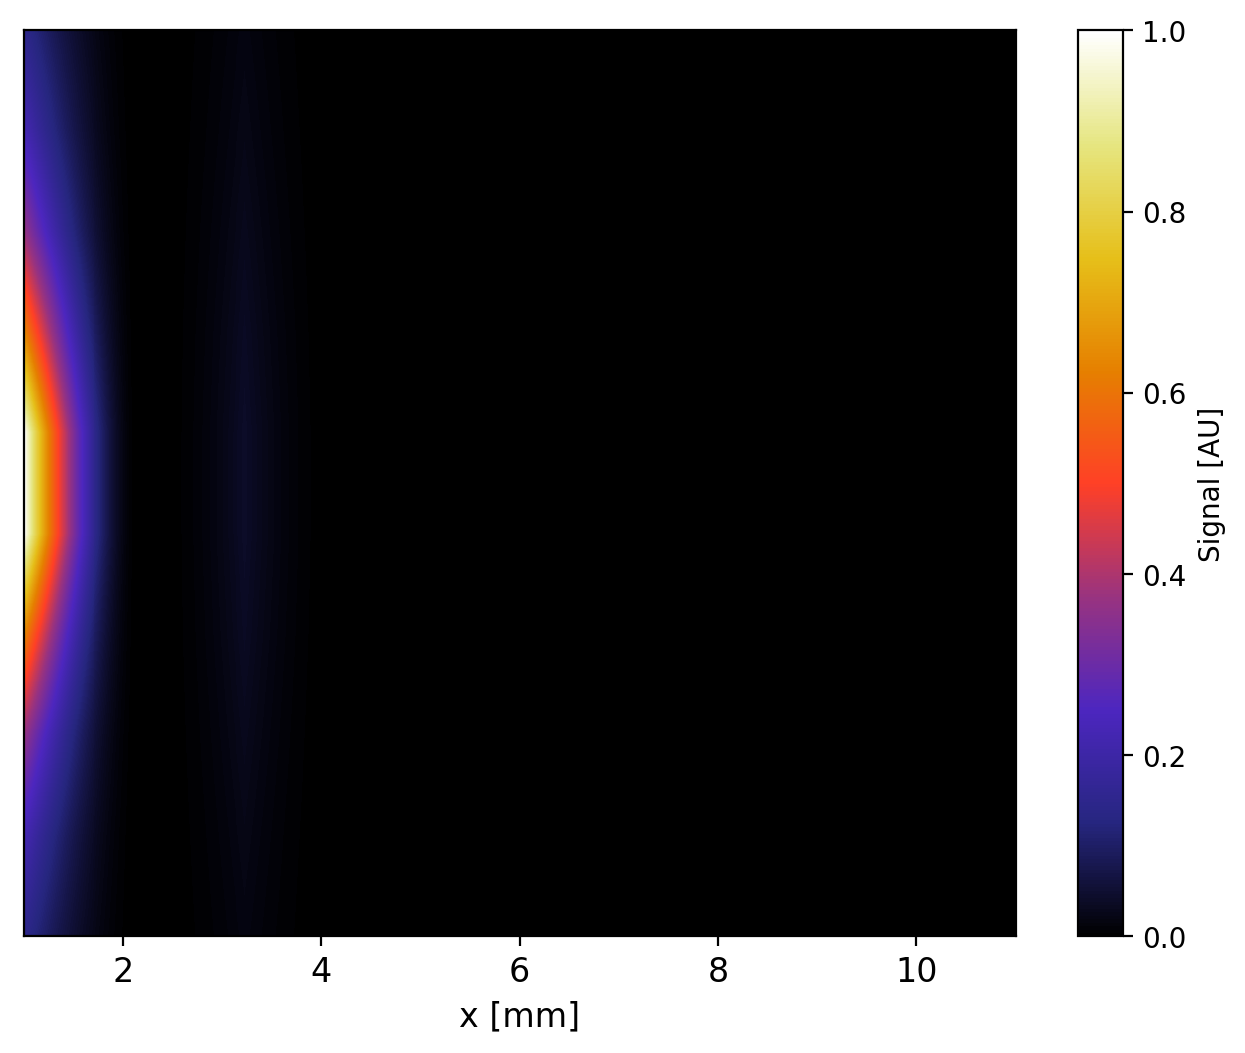

In [32]:
plot_sig(int0, np.array([min(x), max(x), min(y), max(y)])*1e3, '', sname = '0mm_off_sig.svg')

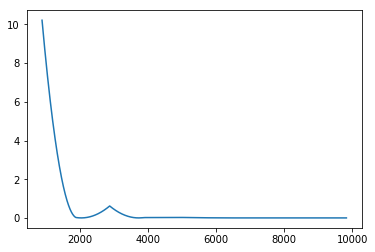

In [33]:
sig = np.sin(int0 / 2)**2;
sig = np.sum(sig, axis = 1);
#sig = sig / max(sig);
plt.plot(x_interp / c * np.tan(angle) * 1e15, sig);
plt.show()

In [ ]:
# Get drive and witness peaks
plt.plot(tau * 1e15, gamma0[0, :]);
plt.show();
find_peaks(gamma0[:, 0], height = 0.15)

In [14]:
print(tau[302] * 1e15, tau[533] * 1e15)

604.6046046046047 1067.0670670670672


In [13]:
drive_ind = 302; wit_ind = 533;
x_ind = 0;

In [16]:
y_interp = np.linspace(y[0], y[-1], 100);
fsig1    = interp1d(y, int_1);
int_1_int = fsig1(y_interp);

fsig500    = interp1d(y, int_500);
int_500_int = fsig500(y_interp);

fsig100    = interp1d(y, int_100);
int_1_int = fsig100(y_interp);

fsig50    = interp1d(y, int_50);
int_1_int = fsig50(y_interp);

fsig0    = interp1d(y, int_0);
int_1_int = fsig0(y_interp);

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
fig, ax = makefig(x = 8, y = 6, xlab = 'Signal [AU]', ylab = 'y [mm]');
ax.plot(int_1_int, y_interp, label = r'$\Delta y = $ 1 mm');
ax.plot(int_500_int, y_interp, label = r'$\Delta y = $ 500 $\mu$m');
ax.plot(int_100_int, y_interp, label = r'$\Delta y = $ 100 $\mu$');
ax.plot(int_50_int, y_interp, label = r'$\Delta y = $ 50 $\mu$m');
ax.plot(int_0_int, y_interp, label = r'$\Delta y = $ 0');
plt.show();

In [16]:
# Interpolate
x_interp = x;
y_interp = y;
f1   = interp2d(x, y, gamma1[drive_ind, :, :]);
f500 = interp2d(x, y, gamma500[drive_ind, :, :]);
f100 = interp2d(x, y, gamma100[drive_ind, :, :]);
f50  = interp2d(x, y, gamma50[drive_ind, :, :]);
f0   = interp2d(x, y, gamma0[drive_ind, :, :]);

gamma1_drive_int   = f1(x_interp, y_interp);
gamma500_drive_int = f500(x_interp, y_interp);
gamma100_drive_int = f100(x_interp, y_interp);
gamma50_drive_int  = f50(x_interp, y_interp);
gamma0_drive_int   = f0(x_interp, y_interp);

In [17]:
f1   = interp2d(x, y, gamma1[wit_ind, :, :]);
f500 = interp2d(x, y, gamma500[wit_ind, :, :]);
f100 = interp2d(x, y, gamma100[wit_ind, :, :]);
f50  = interp2d(x, y, gamma50[wit_ind, :, :]);
f0   = interp2d(x, y, gamma0[wit_ind, :, :]);

gamma1_wit_int   = f1(x_interp, y_interp);
gamma500_wit_int = f500(x_interp, y_interp);
gamma100_wit_int = f100(x_interp, y_interp);
gamma50_wit_int  = f50(x_interp, y_interp);
gamma0_wit_int   = f0(x_interp, y_interp);

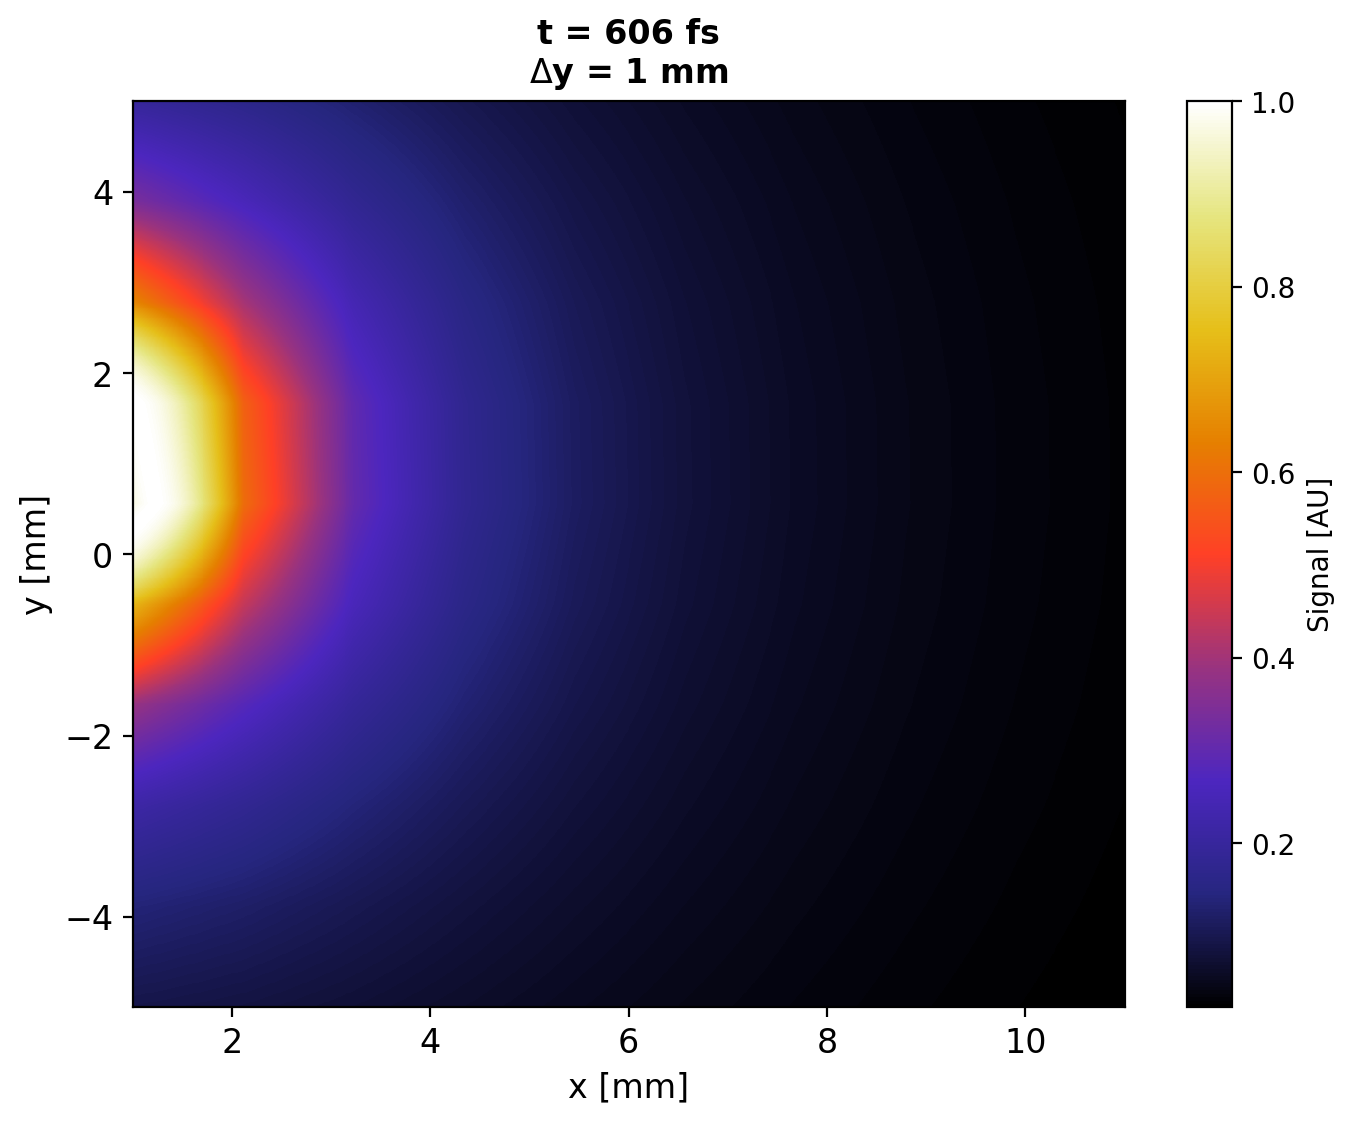

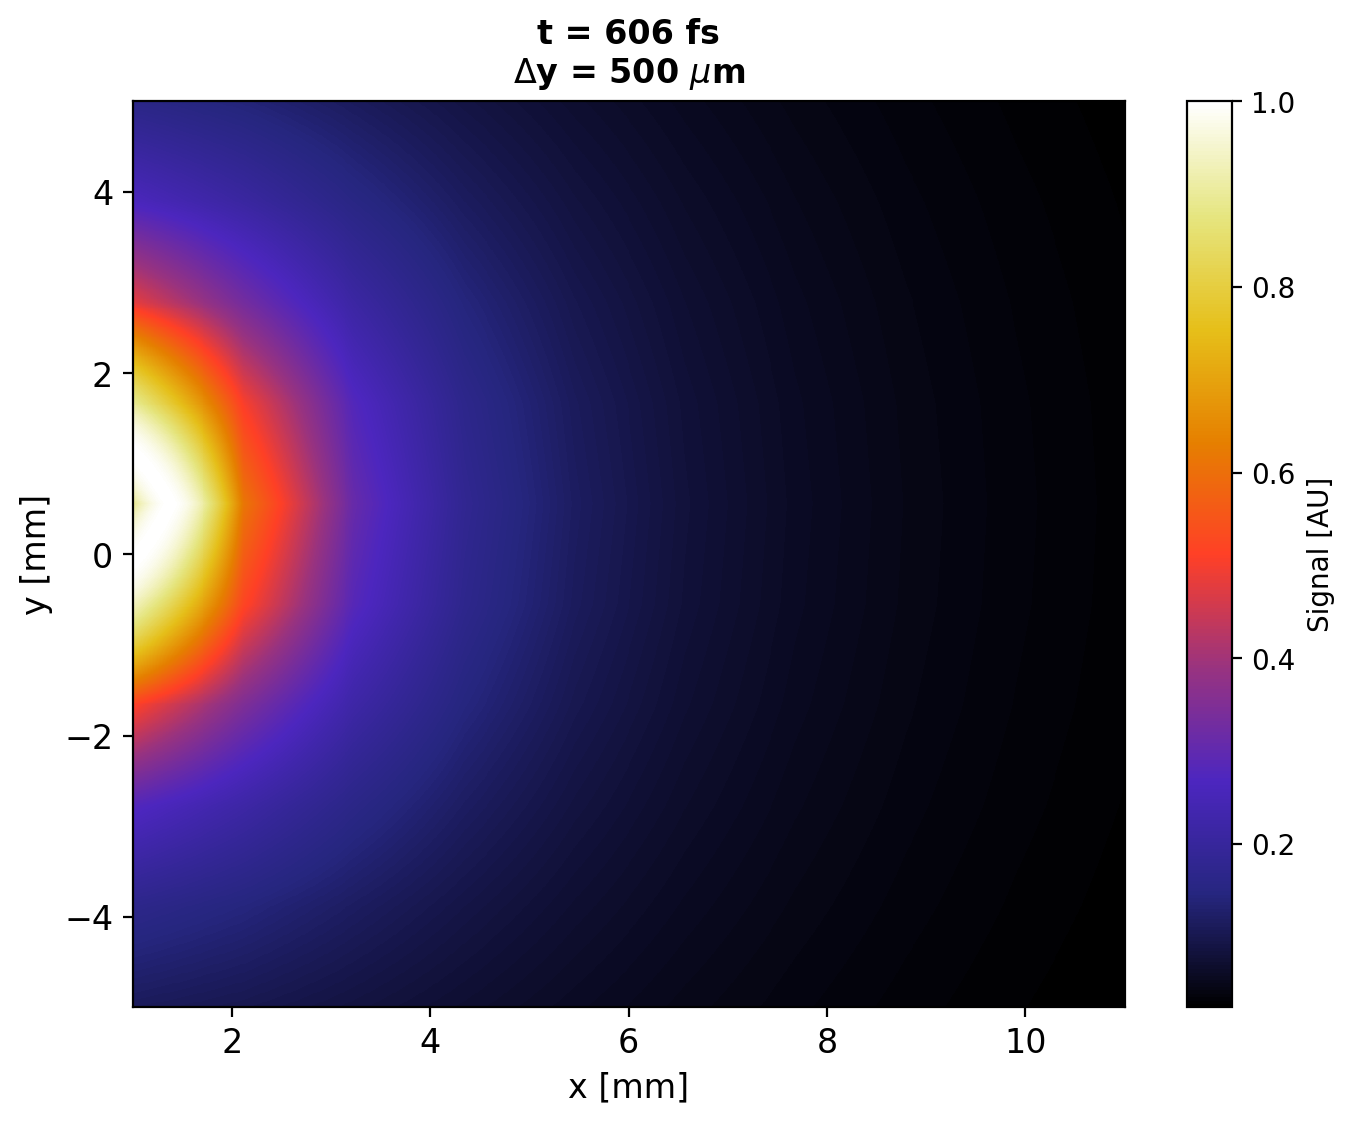

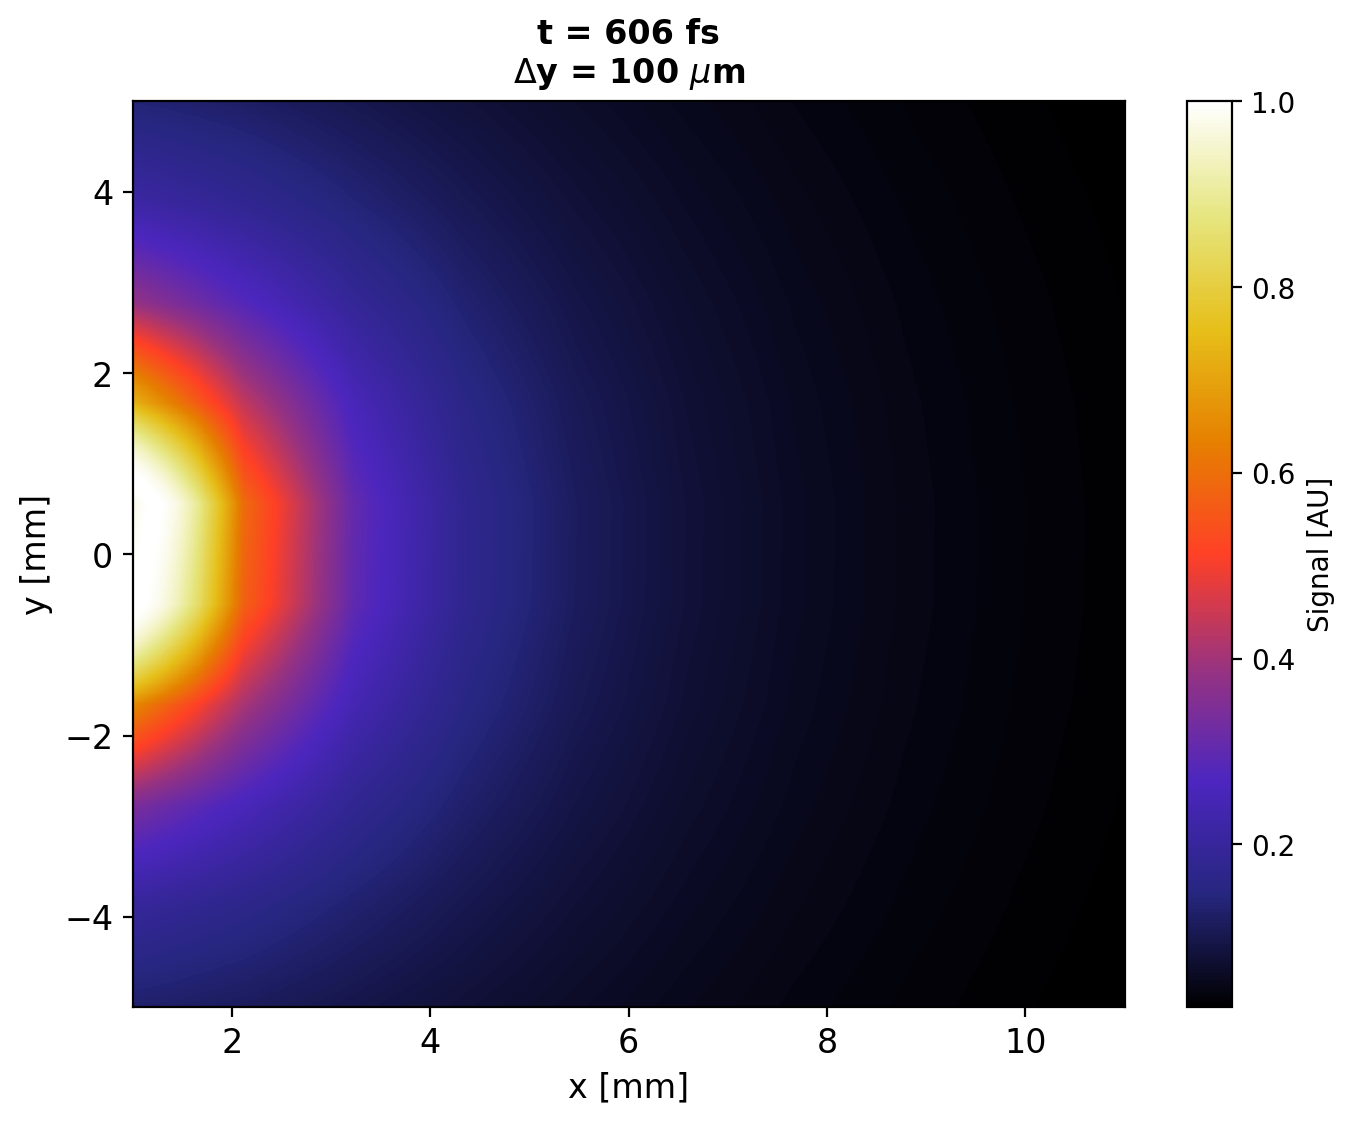

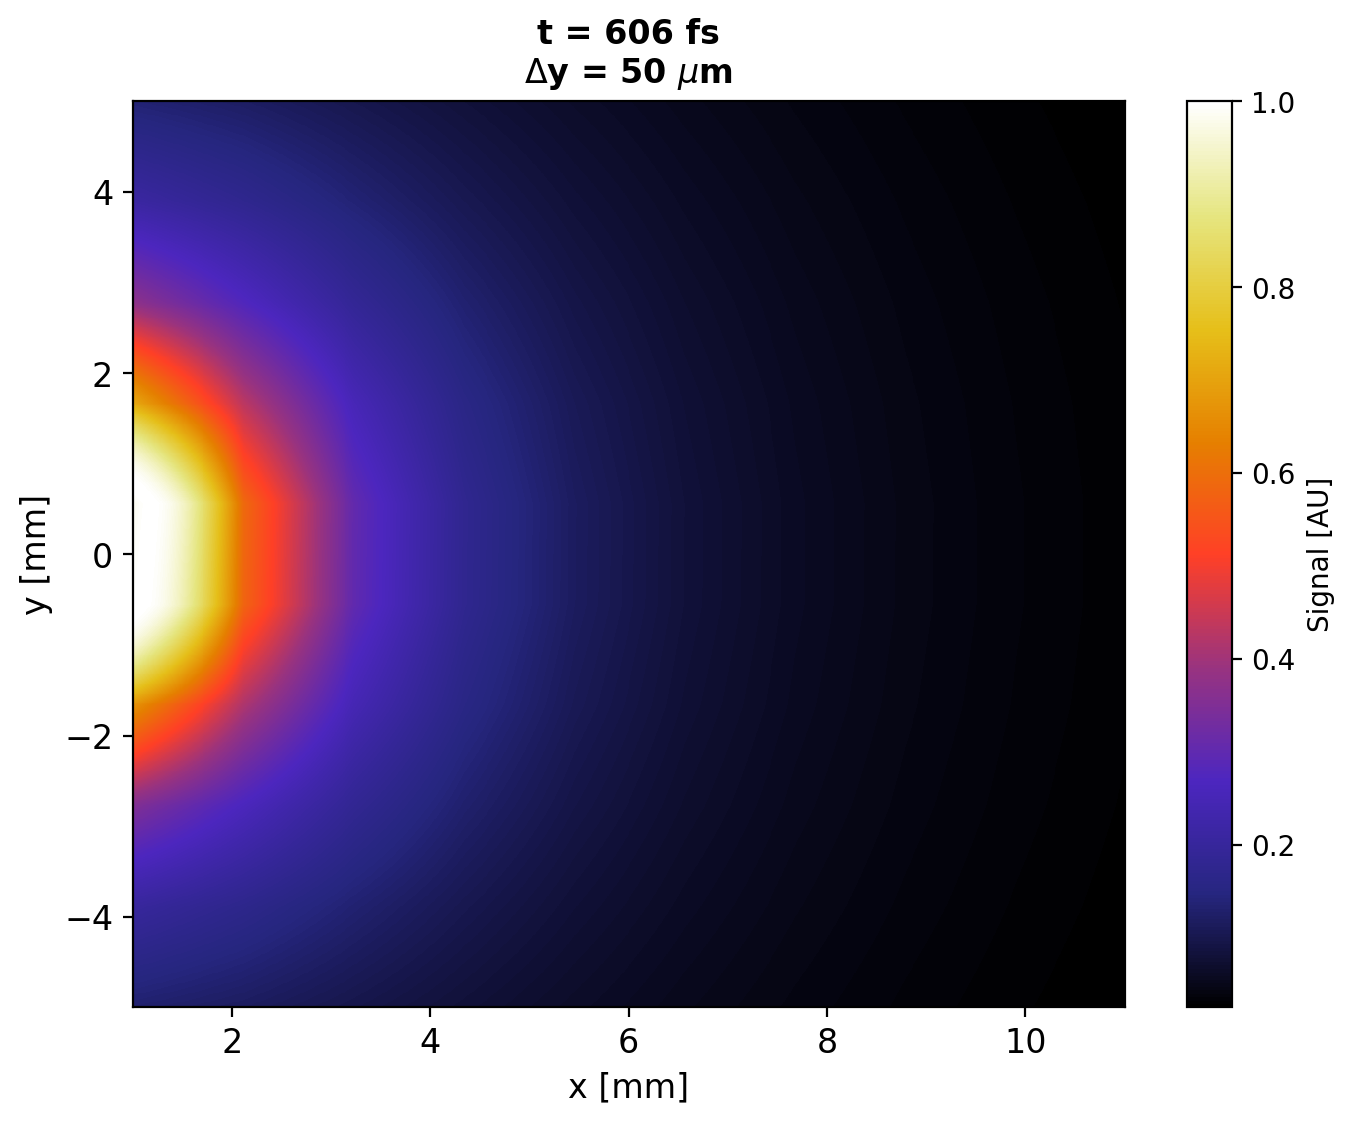

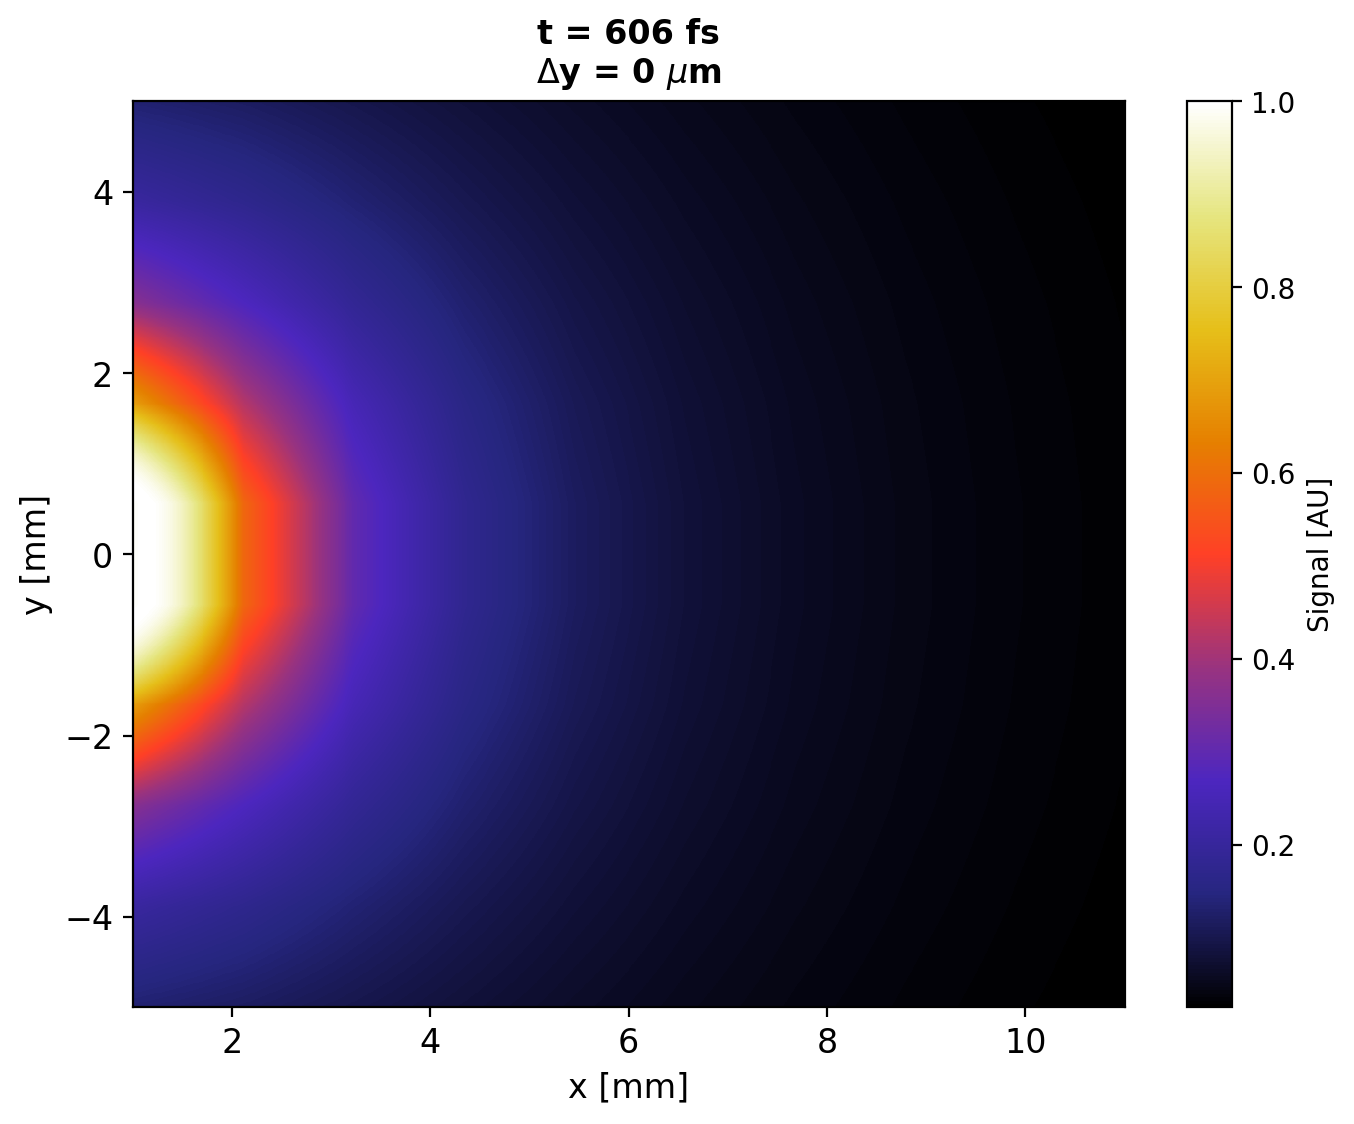

In [19]:
# Drive Phase retardation (crystal 1mm from beamline)
sname = 'drive_1mmsig_'
xline = 0;
phase = False;
drive_sig1 = gamma1_drive_int;
ext = np.array([min(x), max(x), min(y), max(y)]) * 1e3;
tstring = "t = 606 fs" + "\n" +  r'$\Delta$y = 1 mm'
plot_sig(drive_sig1, ext, tstring, xline = xline, phase = phase, sname = sname + '1mm_off.svg')

drive_sig500 = gamma500_drive_int;
ext = np.array([min(x), max(x), min(y), max(y)]) * 1e3;
tstring = "t = 606 fs" + "\n" +  r'$\Delta$y = 500 $\mu$m'
plot_sig(drive_sig500, ext, tstring, xline = xline, phase = phase, sname = sname + '500um_off.svg')

drive_sig100 = gamma100_drive_int;
ext = np.array([min(x), max(x), min(y), max(y)]) * 1e3;
tstring = "t = 606 fs" + "\n" +  r'$\Delta$y = 100 $\mu$m'
plot_sig(drive_sig100, ext, tstring, xline = xline, phase = phase, sname = sname + '100um_off.svg')

drive_sig50 = gamma50_drive_int;
ext = np.array([min(x), max(x), min(y), max(y)]) * 1e3;
tstring = "t = 606 fs" + "\n" +  r'$\Delta$y = 50 $\mu$m'
plot_sig(drive_sig50, ext, tstring, xline = xline, phase = phase, sname = sname + '50um_off.svg')

drive_sig0 = gamma0_drive_int;
ext = np.array([min(x), max(x), min(y), max(y)]) * 1e3;
tstring = "t = 606 fs" + "\n" +  r'$\Delta$y = 0 $\mu$m'
plot_sig(drive_sig0, ext, tstring, xline = xline, phase = phase, sname = sname + '0_off.svg')

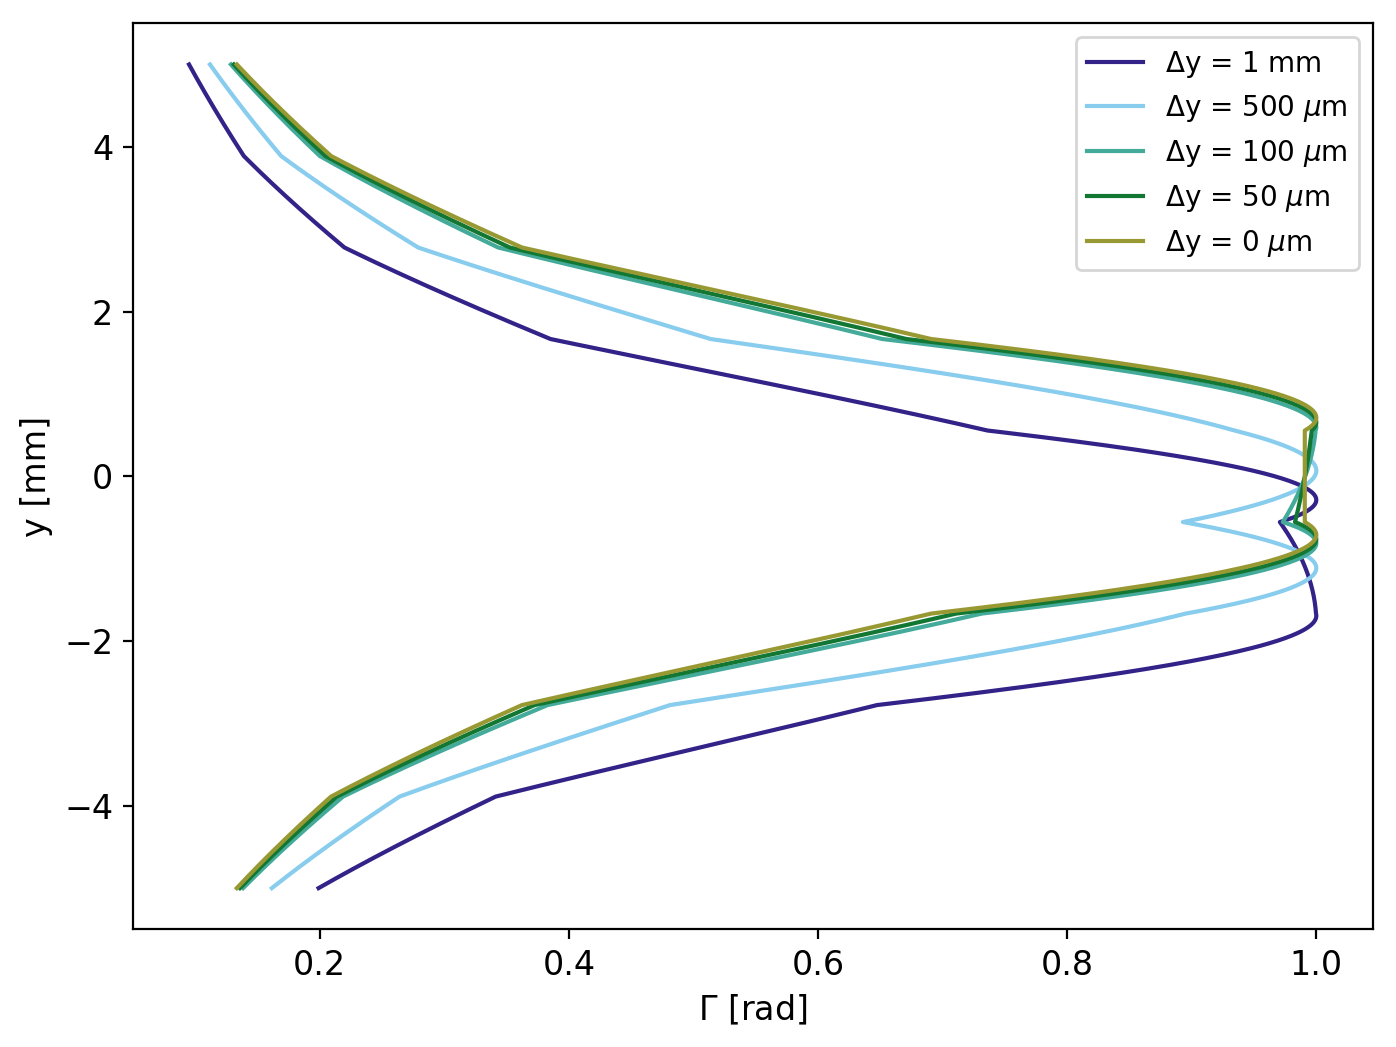

In [24]:
#Lineouts
fig, ax = makefig(x = 8, y = 6, xlab = r'$\Gamma$ [rad]', ylab = 'y [mm]');
x_ind = np.argmin(abs(x - 1e-3));
line1   = np.sin(gamma1_drive_int[x_ind, :] / 2)**2;
line500 = np.sin(gamma500_drive_int[x_ind, :] / 2)**2;
line100 = np.sin(gamma100_drive_int[x_ind, :] / 2)**2;
line50  = np.sin(gamma50_drive_int[x_ind, :] / 2)**2;
line0   = np.sin(gamma0_drive_int[x_ind, :] / 2)**2;

#line1   = gamma1[302, x_ind, :];
#line500 = gamma500[302, x_ind, :];
#line100 = gamma100[302, x_ind, :];
#line50  = gamma50[302, x_ind, :];
#line0   = gamma0[302, x_ind, :];


norm = max(line0);
#norm = 1;
ax.plot(line1 / norm, y_interp*1e3, label = r'$\Delta$y = 1 mm');
ax.plot(line500 / norm, y_interp*1e3, label = r'$\Delta$y = 500 $\mu$m');
ax.plot(line100 / norm, y_interp*1e3, label = r'$\Delta$y = 100 $\mu$m');
ax.plot(line50 / norm, y_interp*1e3, label = r'$\Delta$y = 50 $\mu$m');
ax.plot(line0 / norm, y_interp*1e3, label = r'$\Delta$y = 0 $\mu$m');
ax.legend()
fig.savefig('1mmdrive_lineout_1mm.svg')
plt.show()

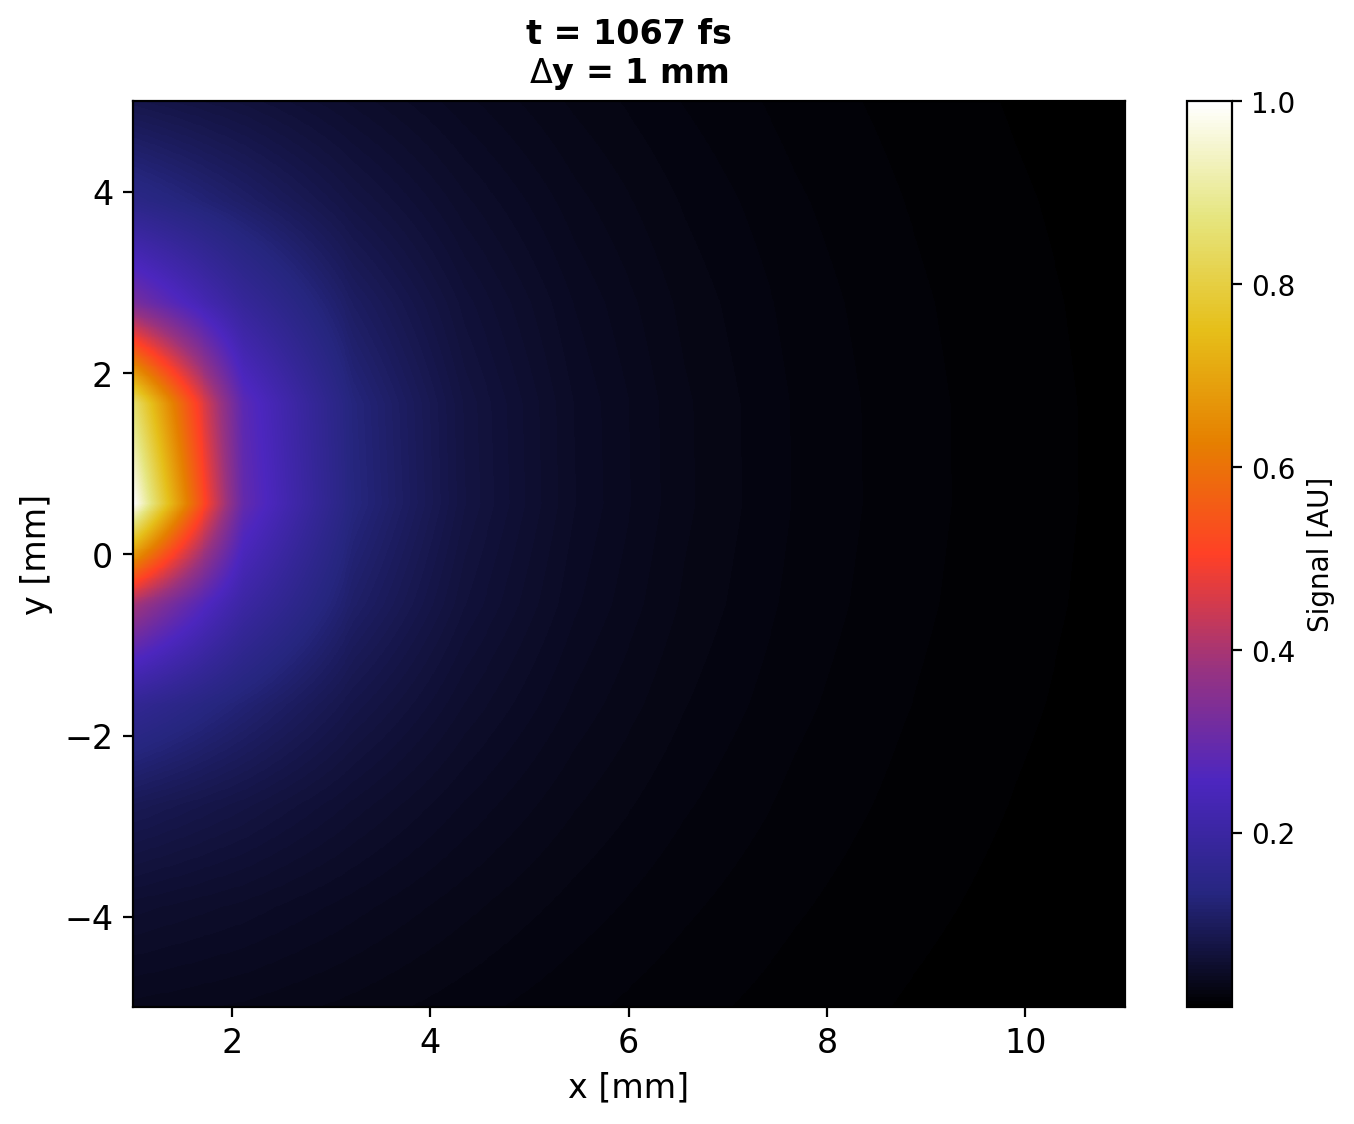

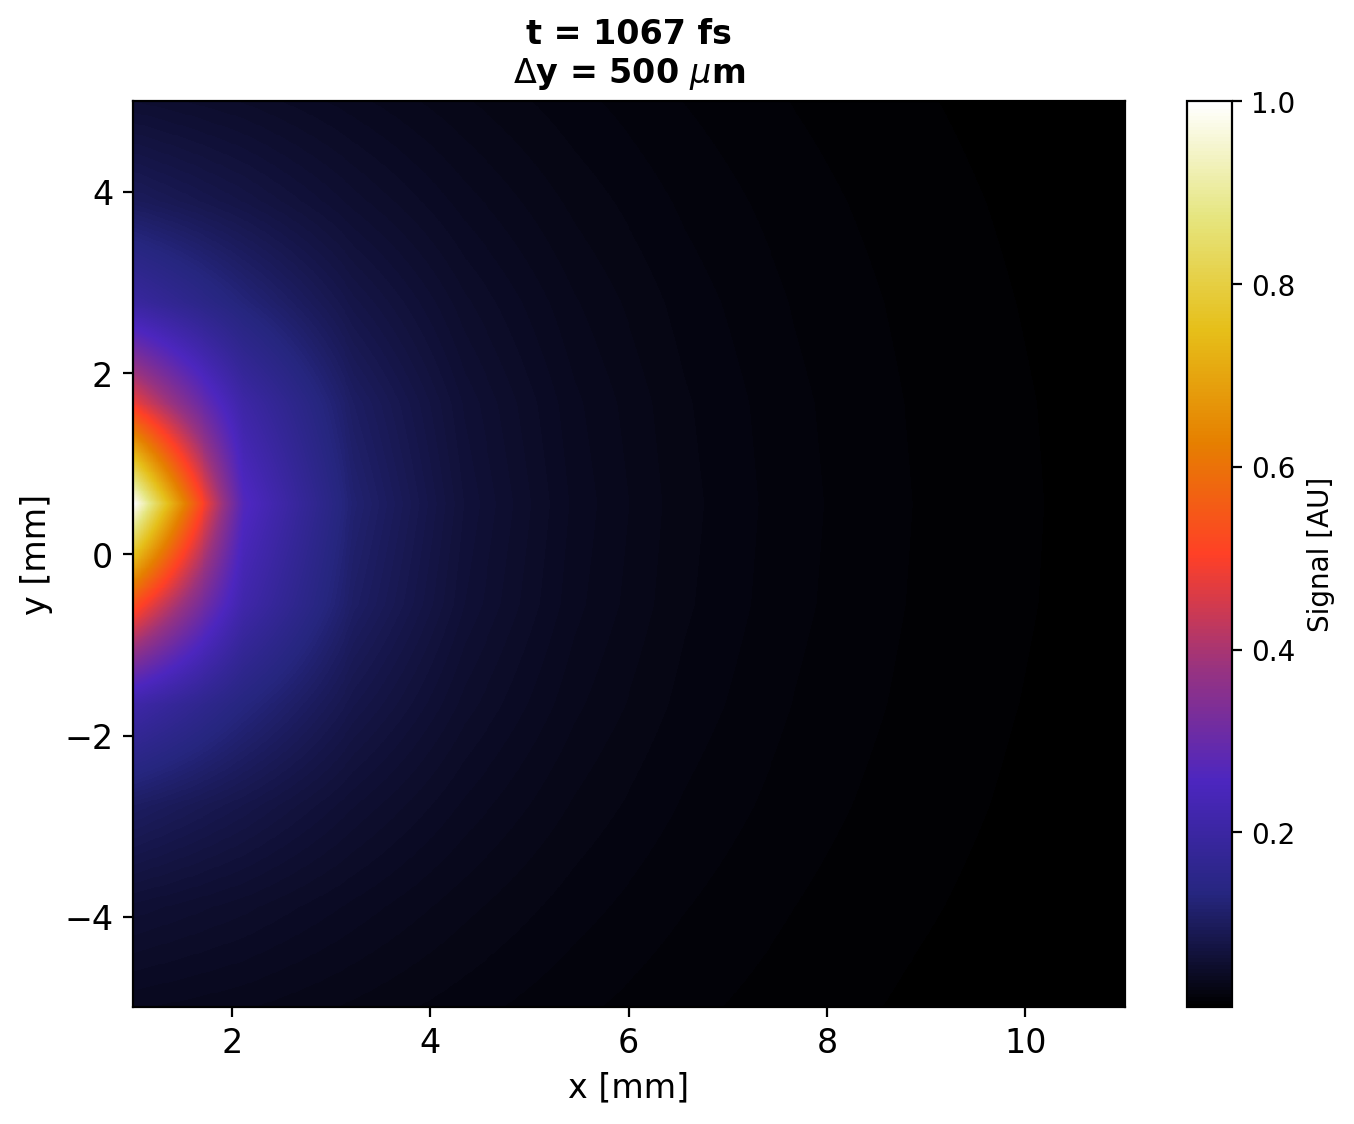

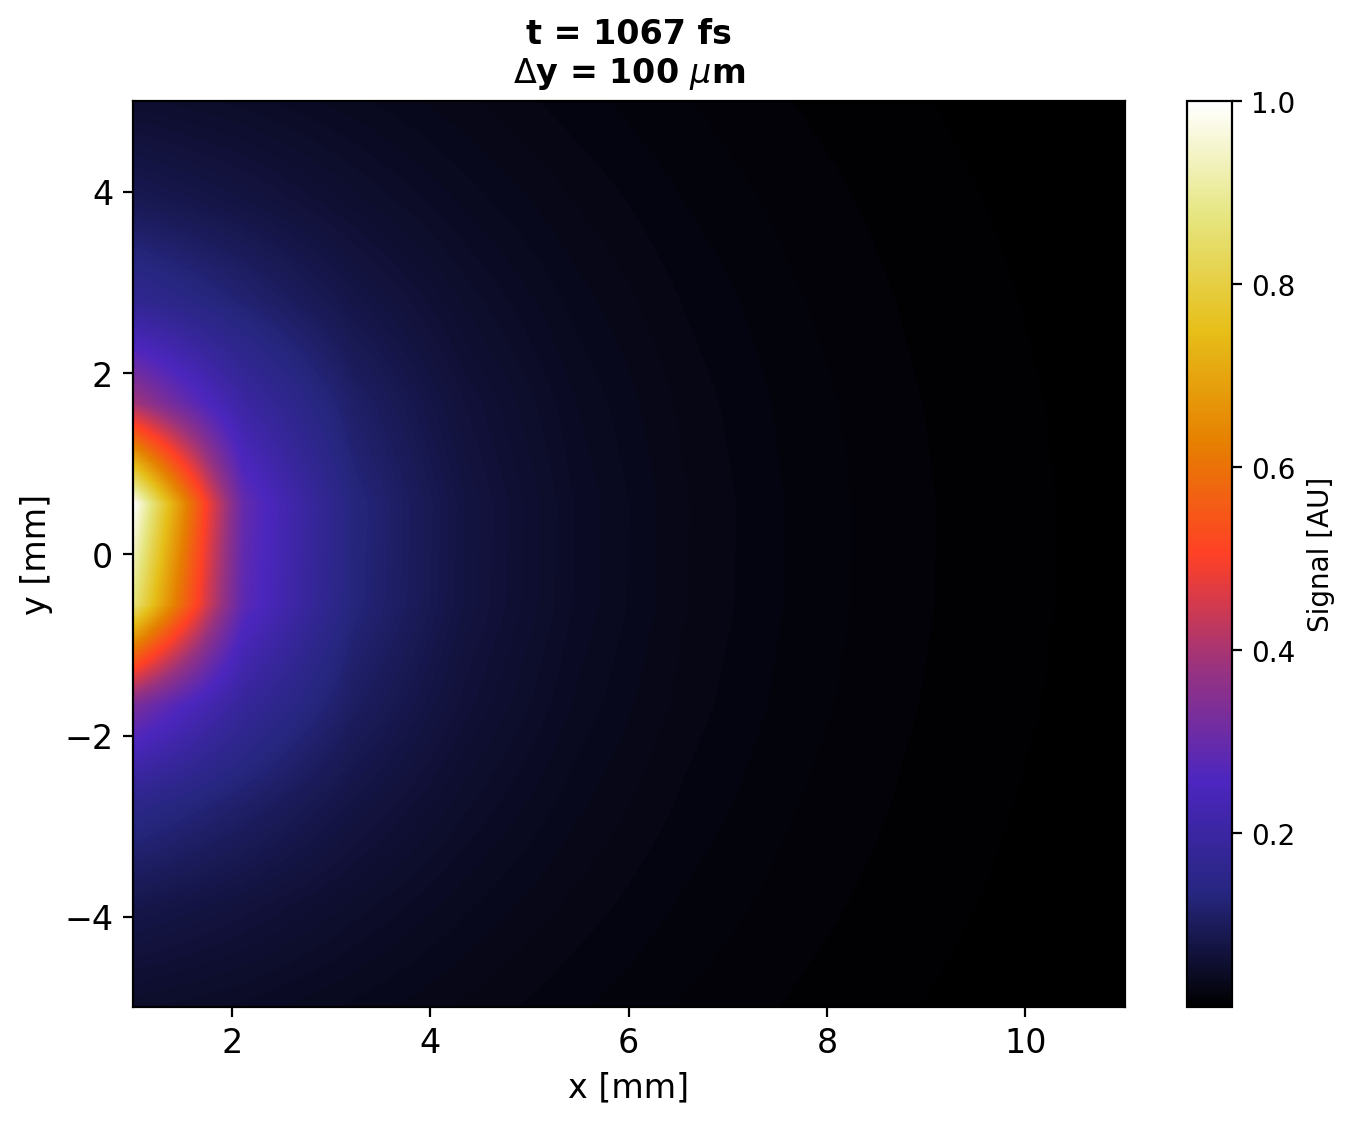

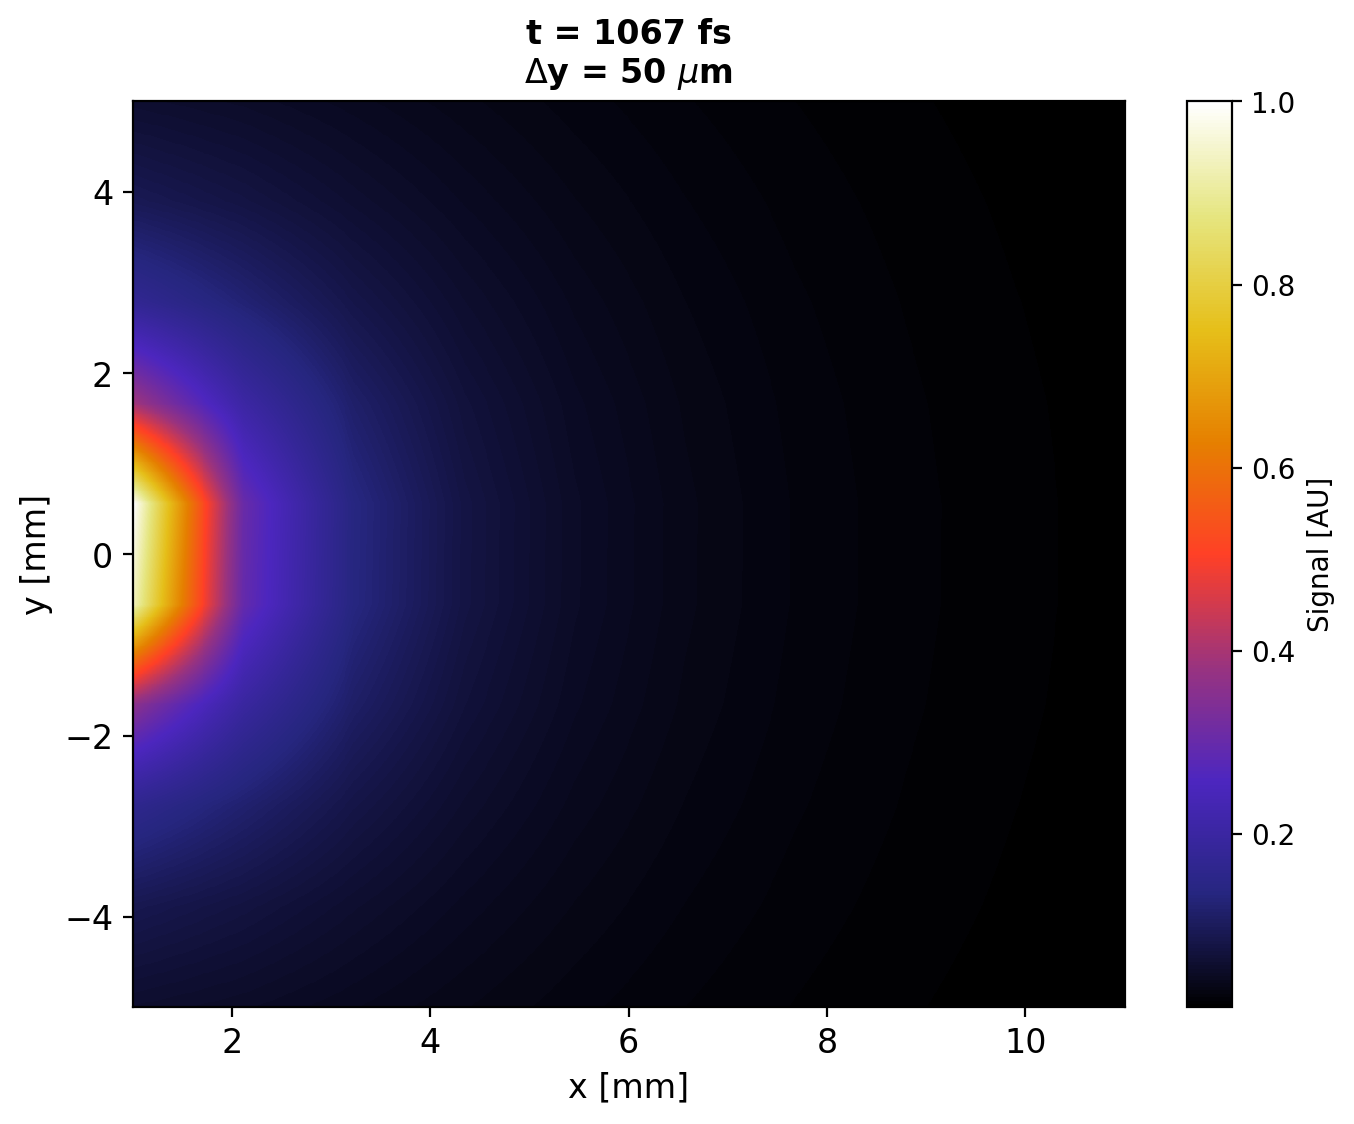

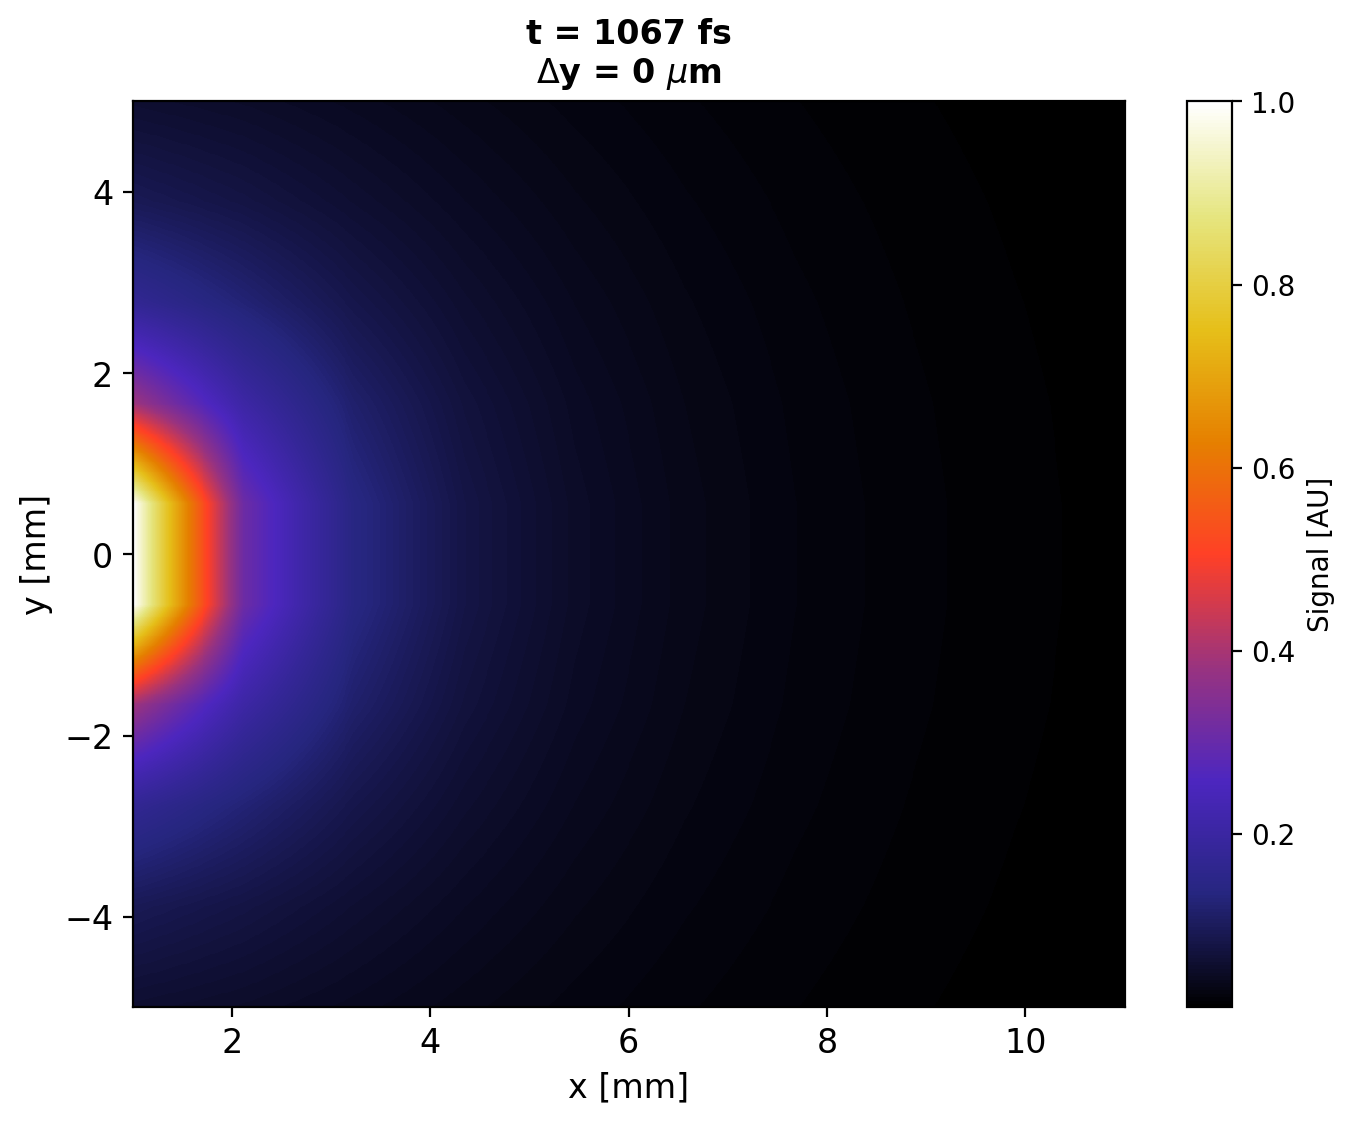

In [25]:
xline = 0;
sname = 'wit_1mmsig_';
phase = False;
wit_sig1   = gamma1_wit_int;
ext = np.array([min(x), max(x), min(y), max(y)]) * 1e3;
tstring = "t = 1067 fs" + "\n" +  r'$\Delta$y = 1 mm'
plot_sig(wit_sig1, ext, tstring, xline = xline, phase = phase, sname = sname + '1mm_off.svg')

wit_sig500   = gamma500_wit_int;
ext = np.array([min(x), max(x), min(y), max(y)]) * 1e3;
tstring = "t = 1067 fs" + "\n" +  r'$\Delta$y = 500 $\mu$m'
plot_sig(wit_sig500, ext, tstring, xline = xline, phase = phase, sname = sname + '500um_off.svg')

wit_sig100   = gamma100_wit_int;
ext = np.array([min(x), max(x), min(y), max(y)]) * 1e3;
tstring = "t = 1067 fs" + "\n" +  r'$\Delta$y = 100 $\mu$m'
plot_sig(wit_sig100, ext, tstring, xline = xline, phase = phase, sname = sname + '100um_off.svg')

wit_sig50   = gamma50_wit_int;
ext = np.array([min(x), max(x), min(y), max(y)]) * 1e3;
tstring = "t = 1067 fs" + "\n" +  r'$\Delta$y = 50 $\mu$m'
plot_sig(wit_sig50, ext, tstring, xline = xline, phase = phase, sname = sname + '50um_off.svg')

wit_sig0   = gamma0_wit_int;
ext = np.array([min(x), max(x), min(y), max(y)]) * 1e3;
tstring = "t = 1067 fs" + "\n" +  r'$\Delta$y = 0 $\mu$m'
plot_sig(wit_sig0, ext, tstring, xline = xline, phase = phase, sname = sname + '0_off.svg')

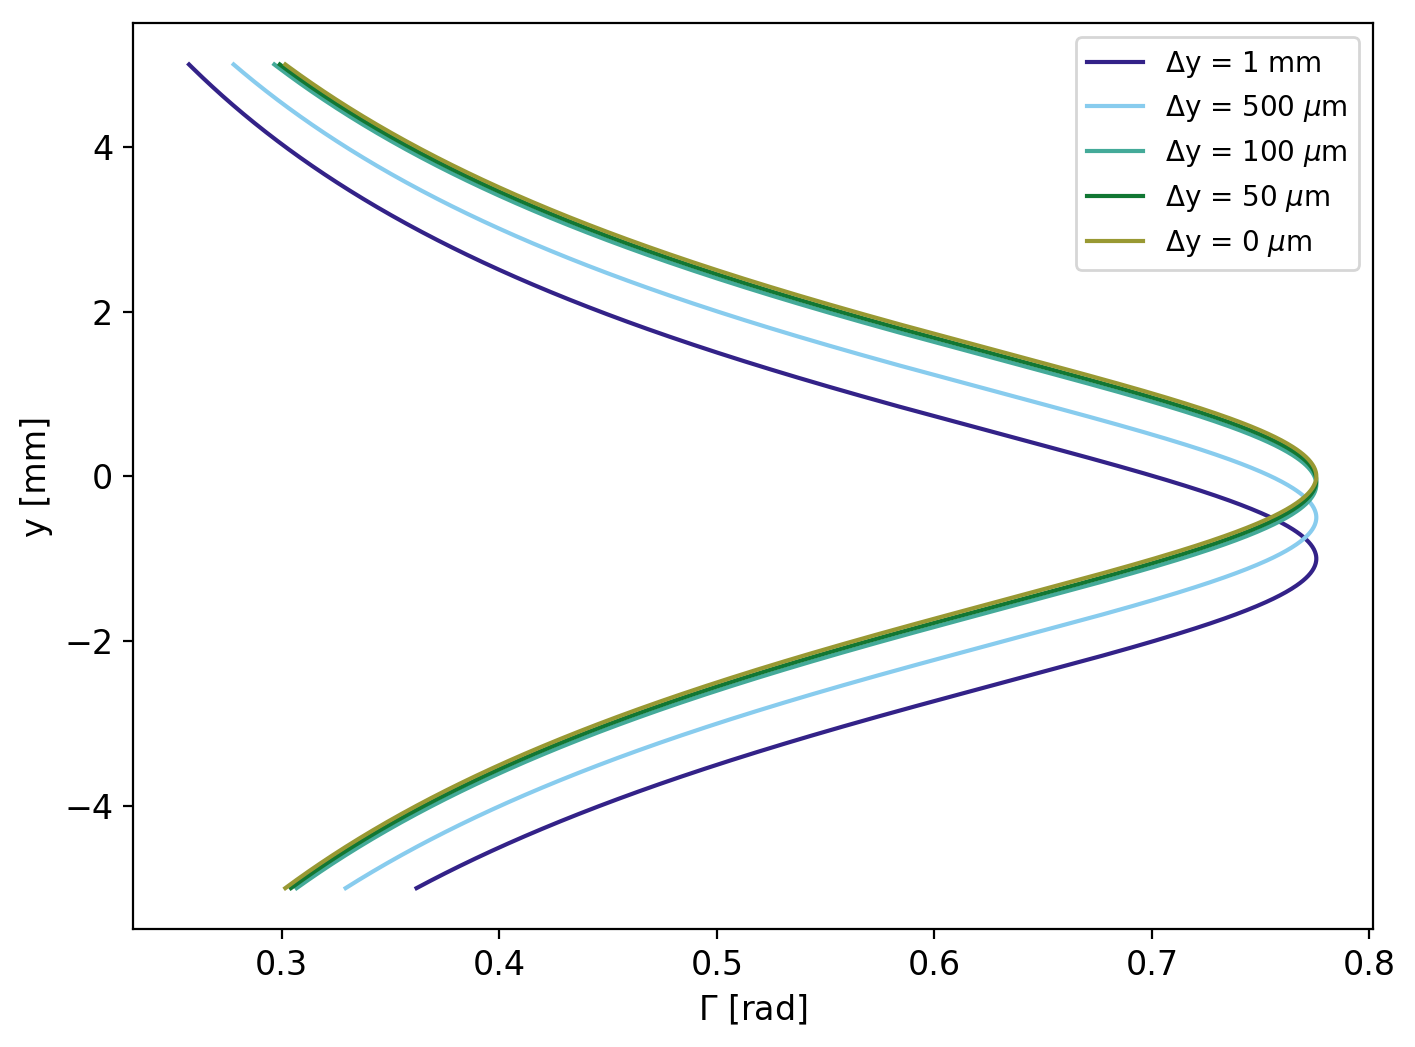

In [22]:
#Lineouts witness
fig, ax = makefig(x = 8, y = 6, xlab = r'$\Gamma$ [rad]', ylab = 'y [mm]');
x_ind = np.argmin(abs(x - 1.5e-3));
line1   = np.sin(gamma1_int[wit_ind, x_ind, :] / 2)**2;
line500 = np.sin(gamma500_int[wit_ind, x_ind, :] / 2)**2;
line100 = np.sin(gamma100_int[wit_ind, x_ind, :] / 2)**2;
line50  = np.sin(gamma50_int[wit_ind, x_ind, :] / 2)**2;
line0   = np.sin(gamma0_int[wit_ind, x_ind, :] / 2)**2;
norm = max(line0);

#norm = 1
#line1   = gamma1[533, x_ind, :];
#line500 = gamma500[533, x_ind, :];
#line100 = gamma100[533, x_ind, :];
#line50  = gamma50[533, x_ind, :];
#line0   = gamma0[533, x_ind, :];
ax.plot(line1 / norm, y*1e3, label = r'$\Delta$y = 1 mm');
ax.plot(line500 / norm, y*1e3, label = r'$\Delta$y = 500 $\mu$m');
ax.plot(line100 / norm, y*1e3, label = r'$\Delta$y = 100 $\mu$m');
ax.plot(line50 / norm, y*1e3, label = r'$\Delta$y = 50 $\mu$m');
ax.plot(line0 / norm, y*1e3, label = r'$\Delta$y = 0 $\mu$m');

fig.savefig('1mmwit_lineout.svg')
ax.legend()
plt.show()

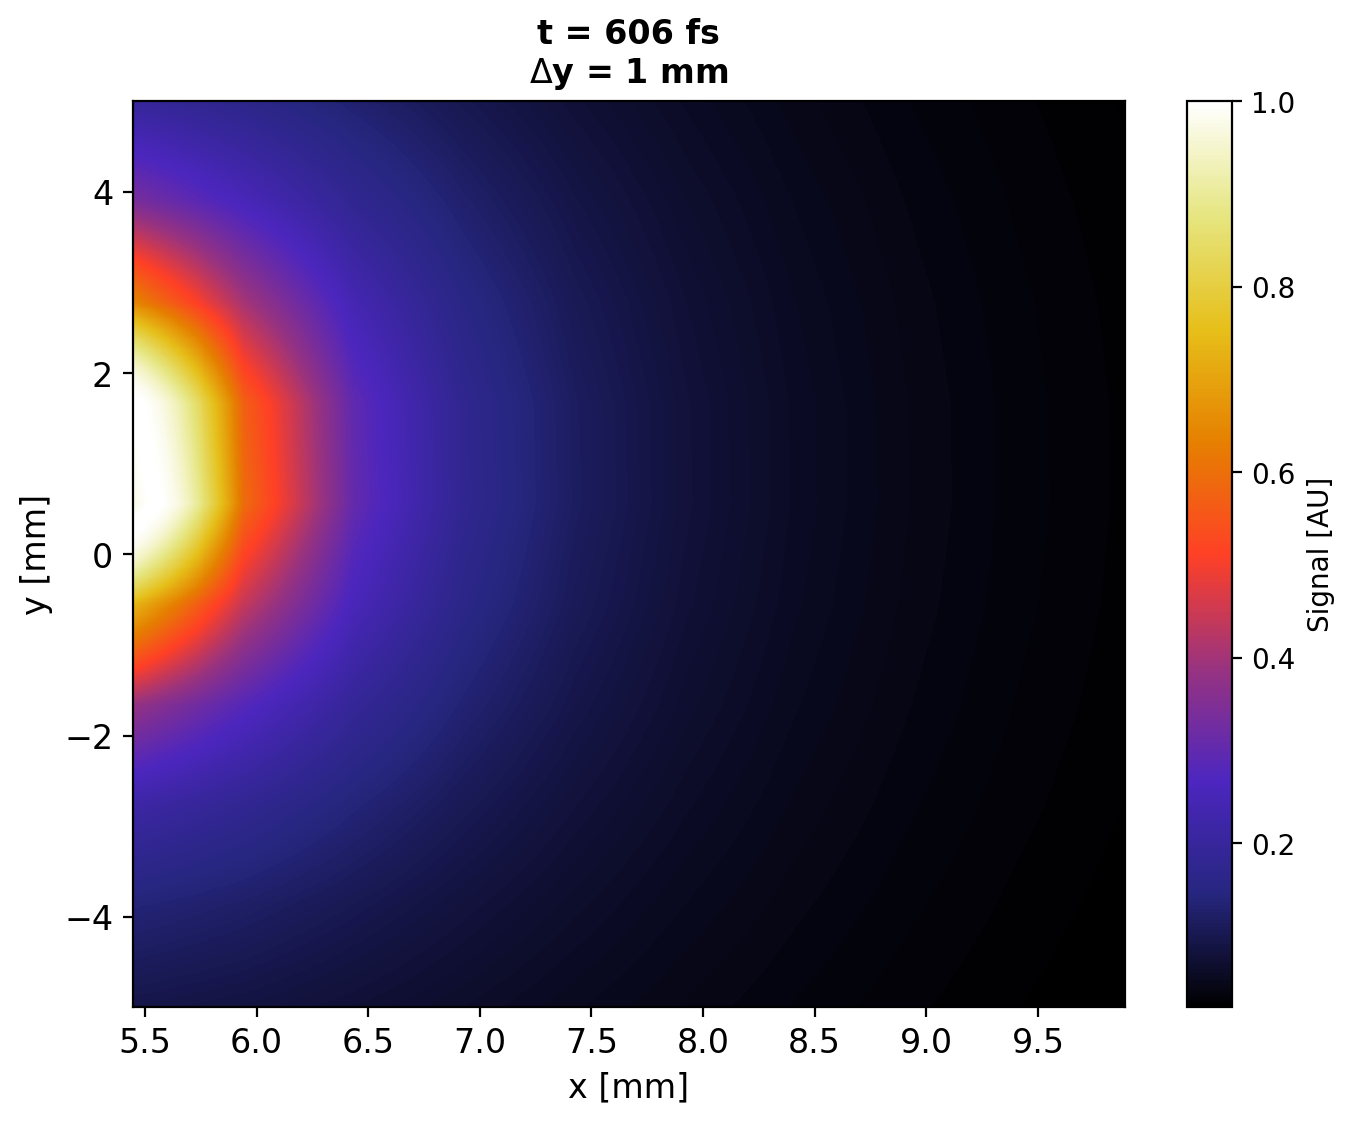

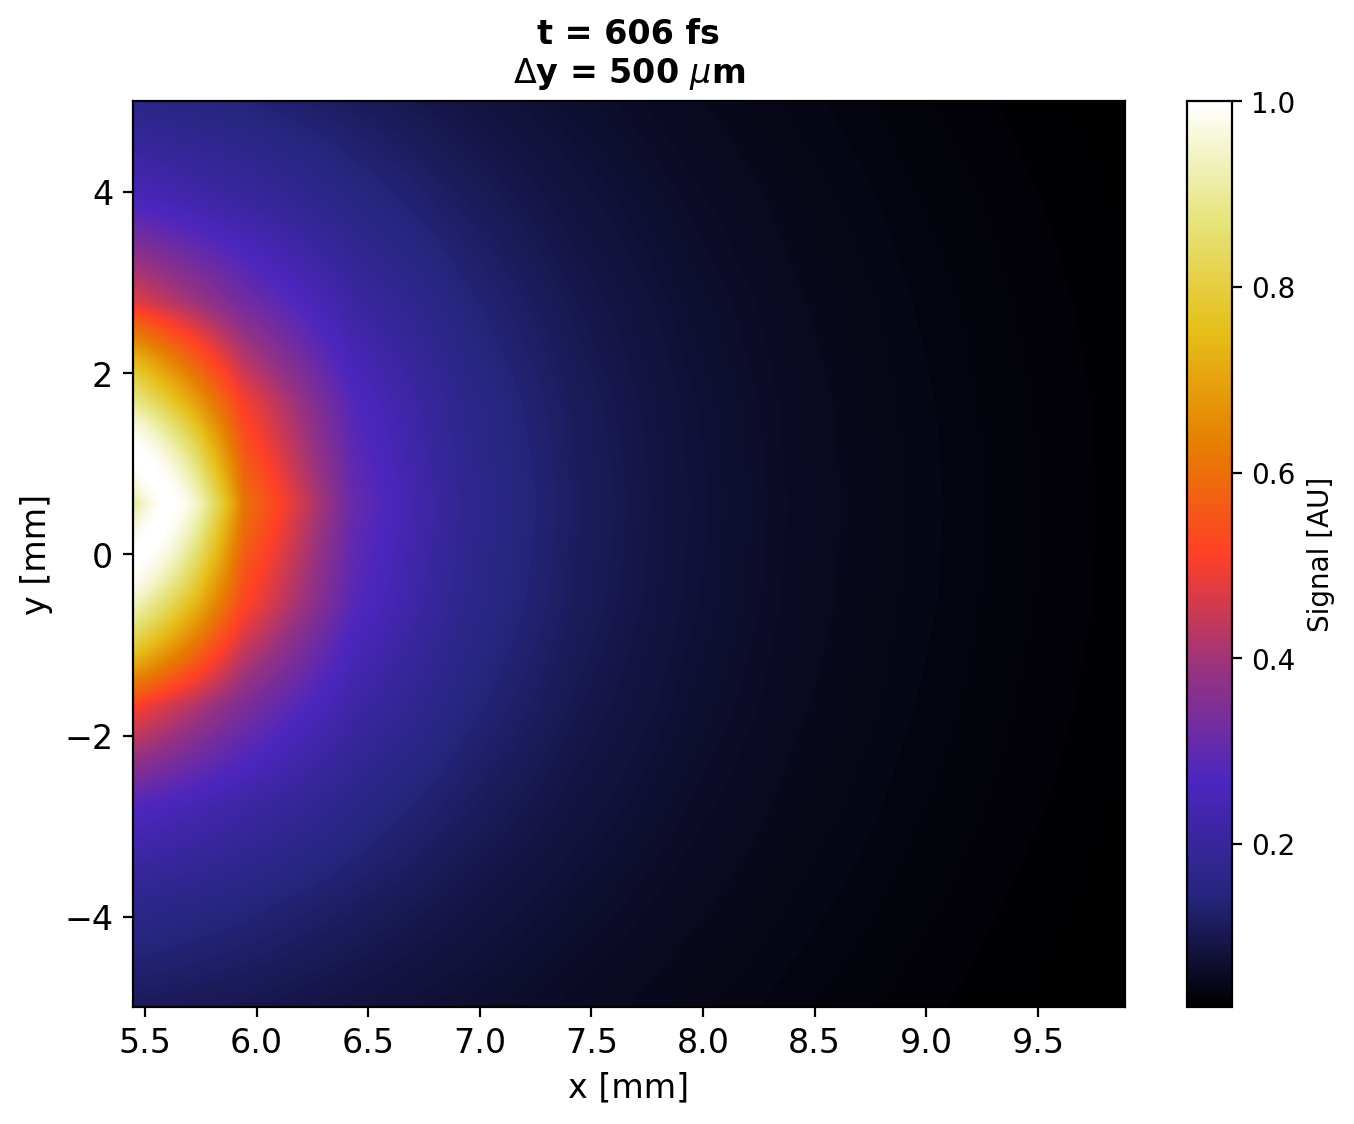

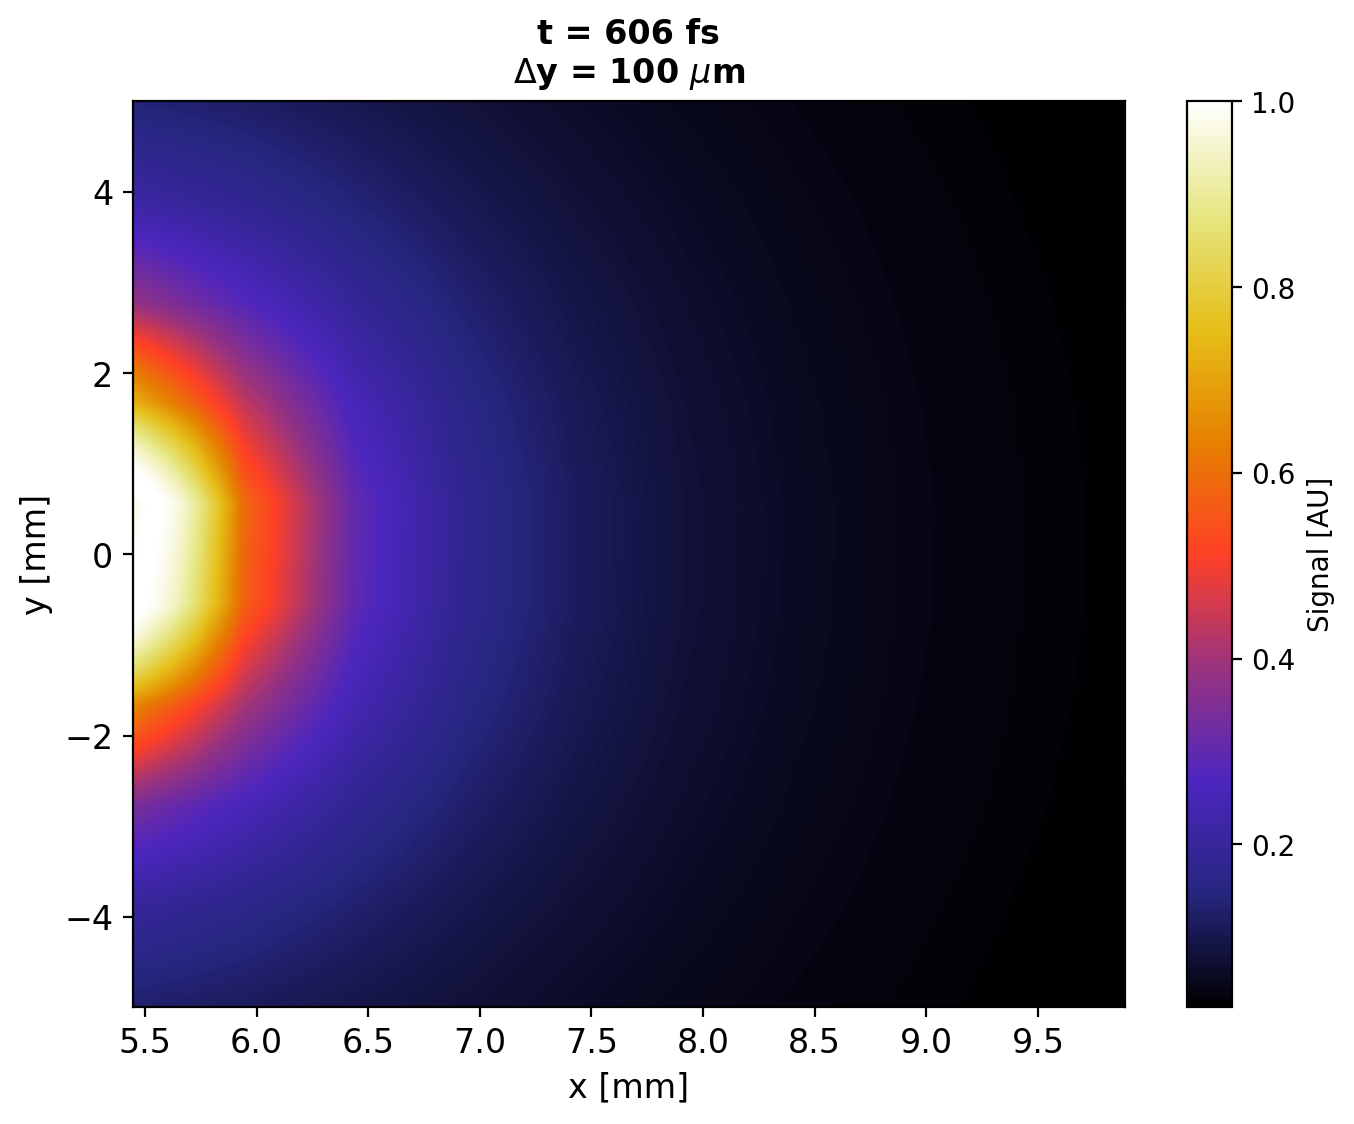

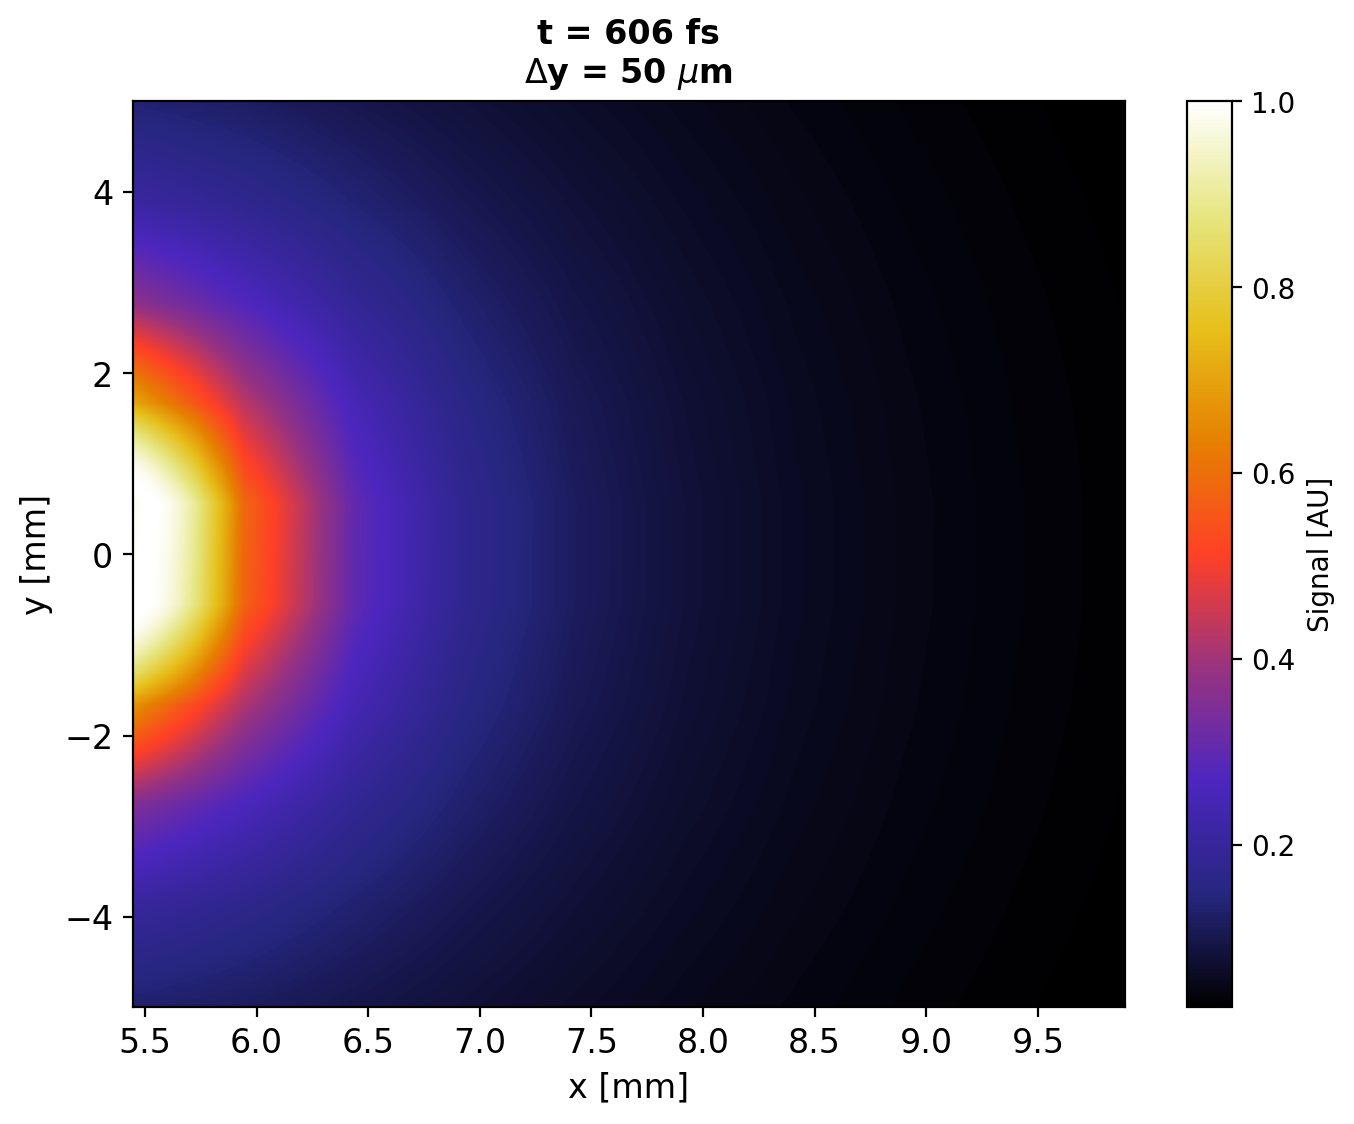

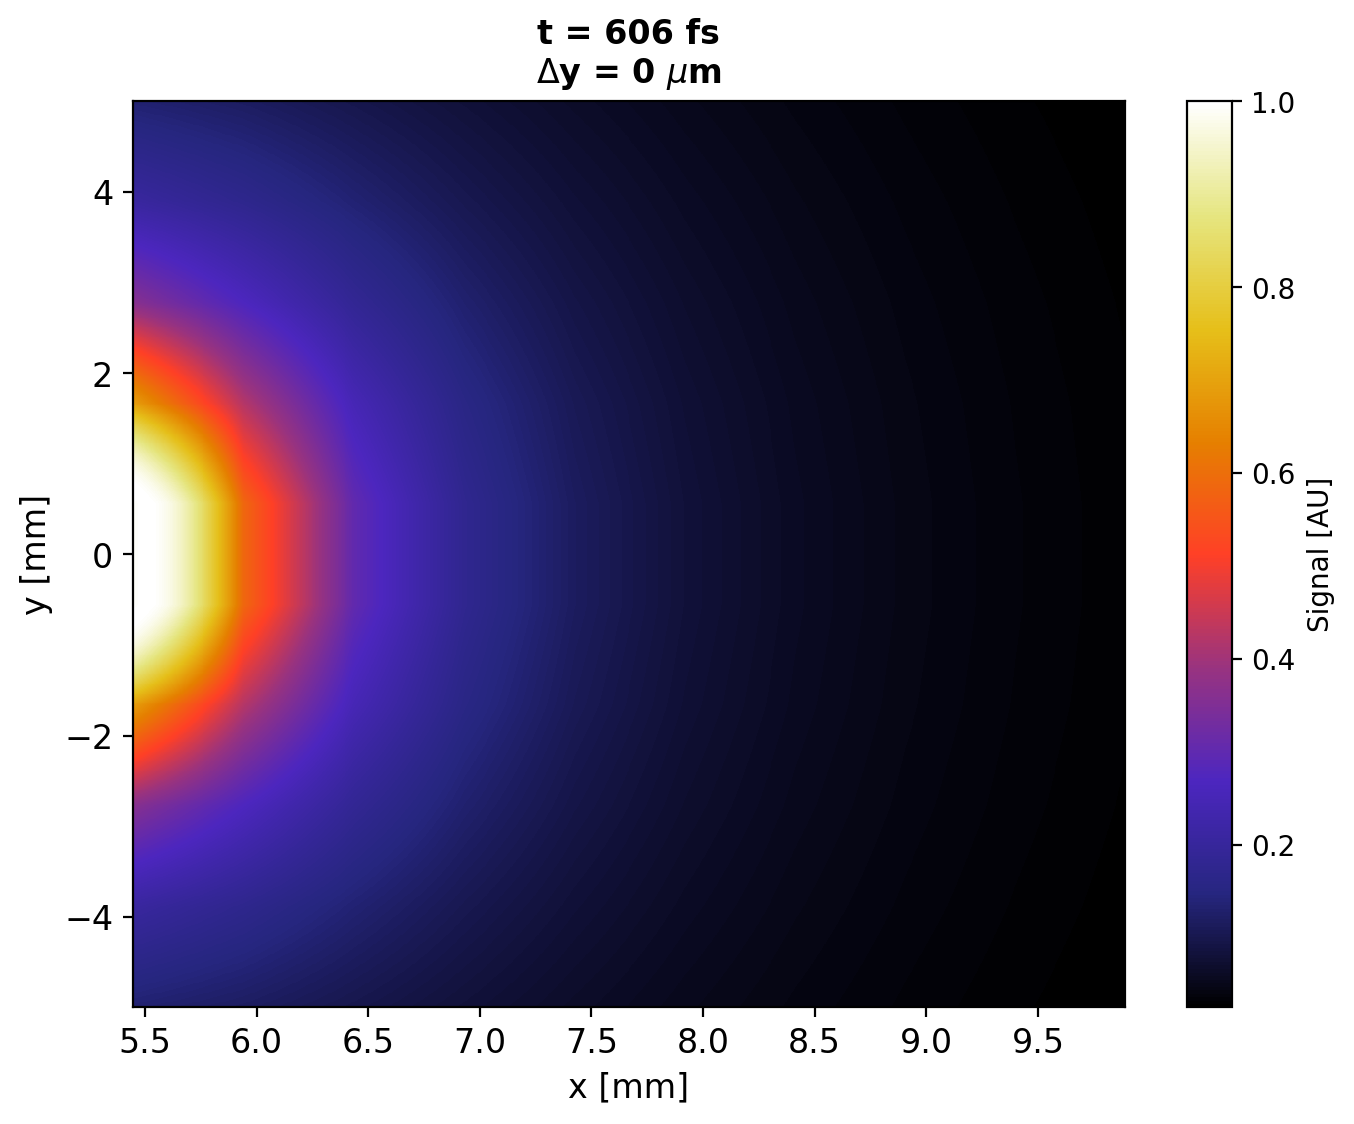

In [26]:
# Drive Phase retardation (crystal 5mm from beamline)
xline = 0;
phase = False;
sname = '5mm_drive_sig_'
x5_ind = np.argmin(abs(x - 5e-3));
x5 = x[x5_ind:-1]
drive_sig1 = gamma1_drive_int;
ext = np.array([min(x5), max(x5), min(y), max(y)]) * 1e3;
tstring = "t = 606 fs" + "\n" +  r'$\Delta$y = 1 mm'
plot_sig(drive_sig1, ext, tstring, xline = xline, phase = phase, sname = sname + '1mm_off.svg')

drive_sig500 = gamma500_drive_int;
ext = np.array([min(x5), max(x5), min(y), max(y)]) * 1e3;
tstring = "t = 606 fs" + "\n" +  r'$\Delta$y = 500 $\mu$m'
plot_sig(drive_sig500, ext, tstring, xline = xline, phase = phase, sname = sname + '500um_off.svg')

drive_sig100 = gamma100_drive_int;
ext = np.array([min(x5), max(x5), min(y), max(y)]) * 1e3;
tstring = "t = 606 fs" + "\n" +  r'$\Delta$y = 100 $\mu$m'
plot_sig(drive_sig100, ext, tstring, xline = xline, phase = phase, sname = sname + '100um_off.svg')

drive_sig50 = gamma50_drive_int;
ext = np.array([min(x5), max(x5), min(y), max(y)]) * 1e3;
tstring = "t = 606 fs" + "\n" +  r'$\Delta$y = 50 $\mu$m'
plot_sig(drive_sig50, ext, tstring, xline = xline, phase = phase, sname = sname + '50um_off.svg')

drive_sig0 = gamma0_drive_int;
ext = np.array([min(x5), max(x5), min(y), max(y)]) * 1e3;
tstring = "t = 606 fs" + "\n" +  r'$\Delta$y = 0 $\mu$m'
plot_sig(drive_sig0, ext, tstring, xline = xline, phase = phase, sname = sname + '0_off.svg')

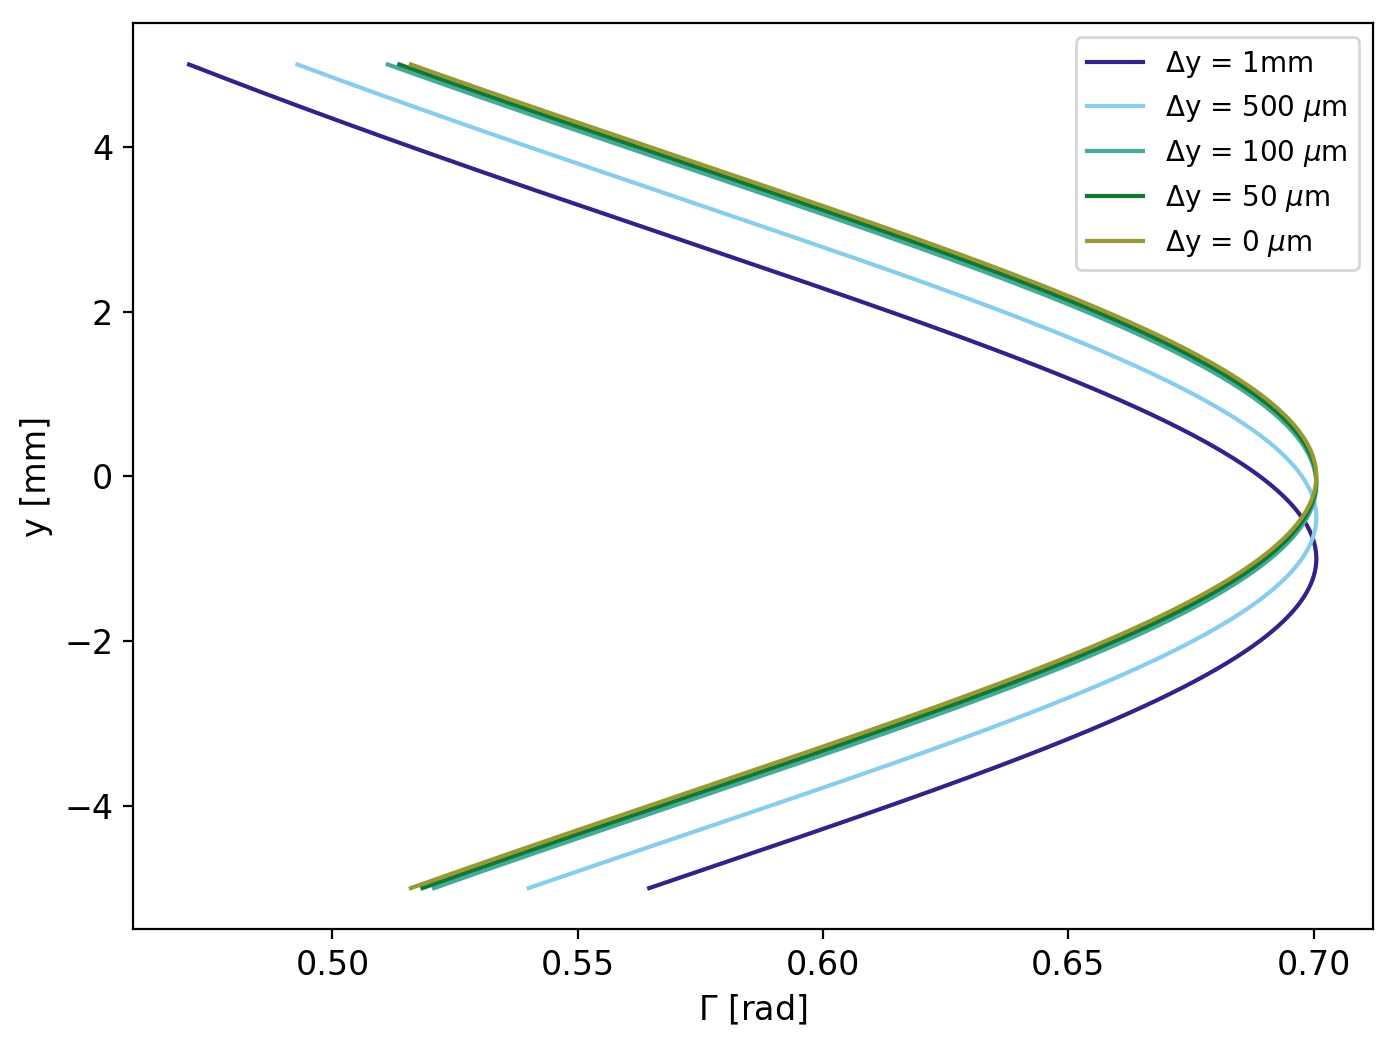

In [23]:
#Lineouts
fig, ax = makefig(x = 8, y = 6, xlab = r'$\Gamma$ [rad]', ylab = 'y [mm]');
x_ind = np.argmin(abs(x - 5.5e-3));
line1   = np.sin(gamma1[302, x_ind, :] / 2)**2;
line500 = np.sin(gamma500[302, x_ind, :] / 2)**2;
line100 = np.sin(gamma100[302, x_ind, :] / 2)**2;
line50  = np.sin(gamma50[302, x_ind, :] / 2)**2;
line0   = np.sin(gamma0[302, x_ind, :] / 2)**2;
norm = max(line0);

#line1   = gamma1[302, x_ind, :];
#line500 = gamma500[302, x_ind, :];
#line100 = gamma100[302, x_ind, :];
#line50  = gamma50[302, x_ind, :];
#line0   = gamma0[302, x_ind, :];
#norm = 1;
ax.plot(line1 / norm, y*1e3, label = r'$\Delta$y = 1mm');
ax.plot(line500 / norm, y*1e3, label = r'$\Delta$y = 500 $\mu$m');
ax.plot(line100 / norm, y*1e3, label = r'$\Delta$y = 100 $\mu$m');
ax.plot(line50 / norm, y*1e3, label = r'$\Delta$y = 50 $\mu$m');
ax.plot(line0 / norm, y*1e3, label = r'$\Delta$y = 0 $\mu$m');
ax.legend()
fig.savefig('5mm_drive_lineout.svg')
plt.show()

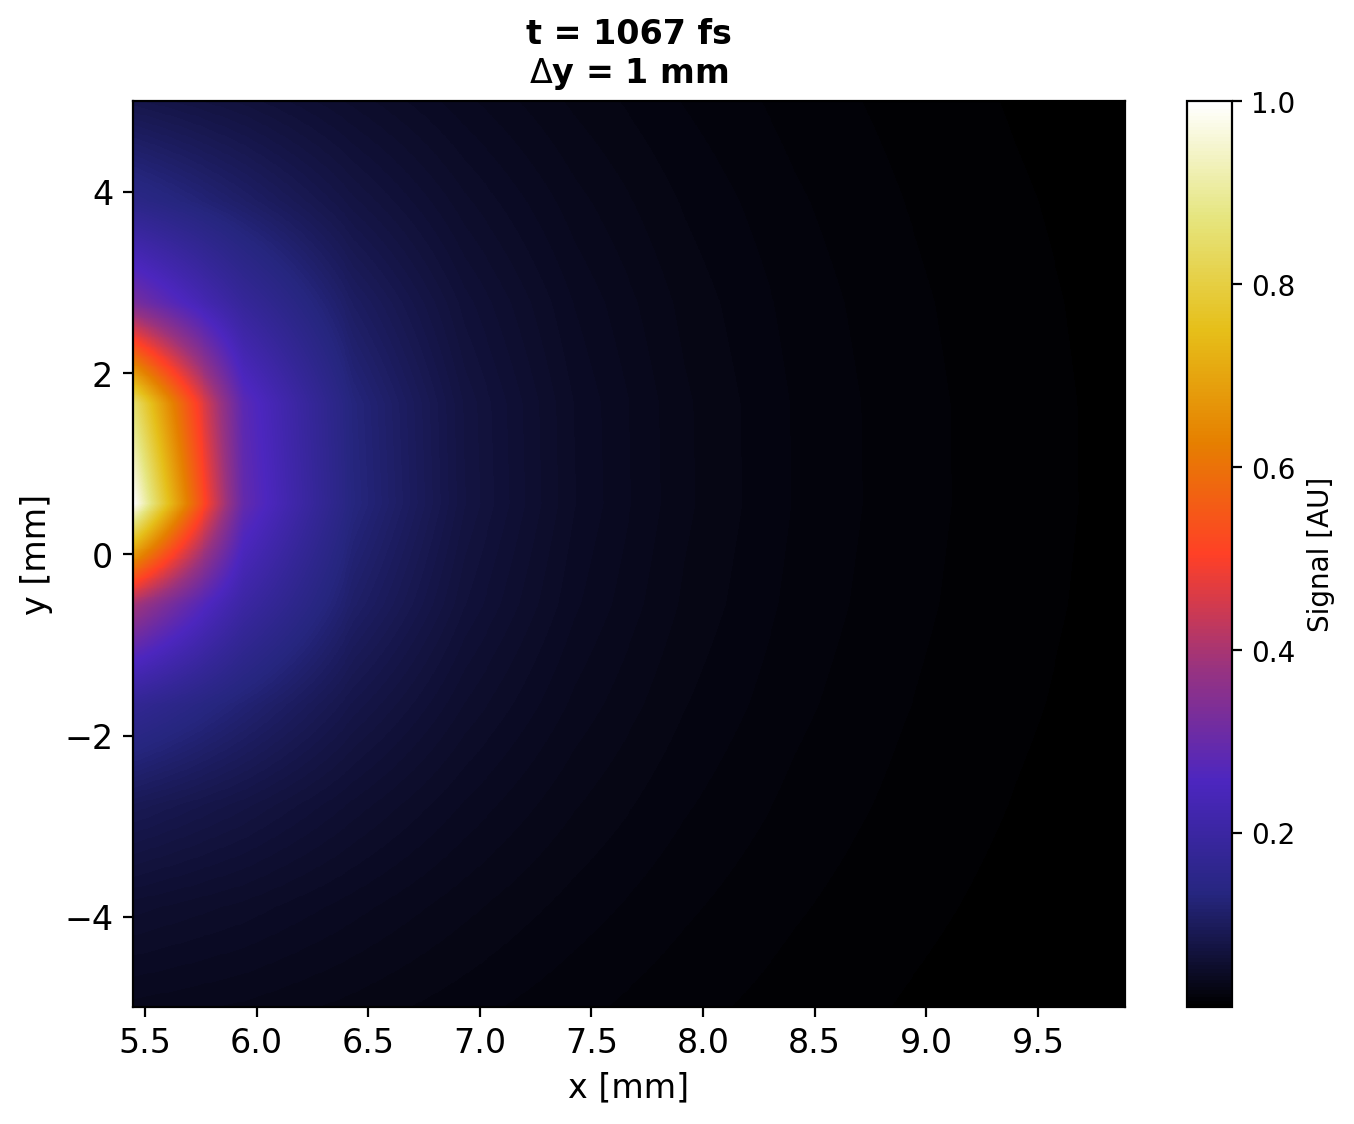

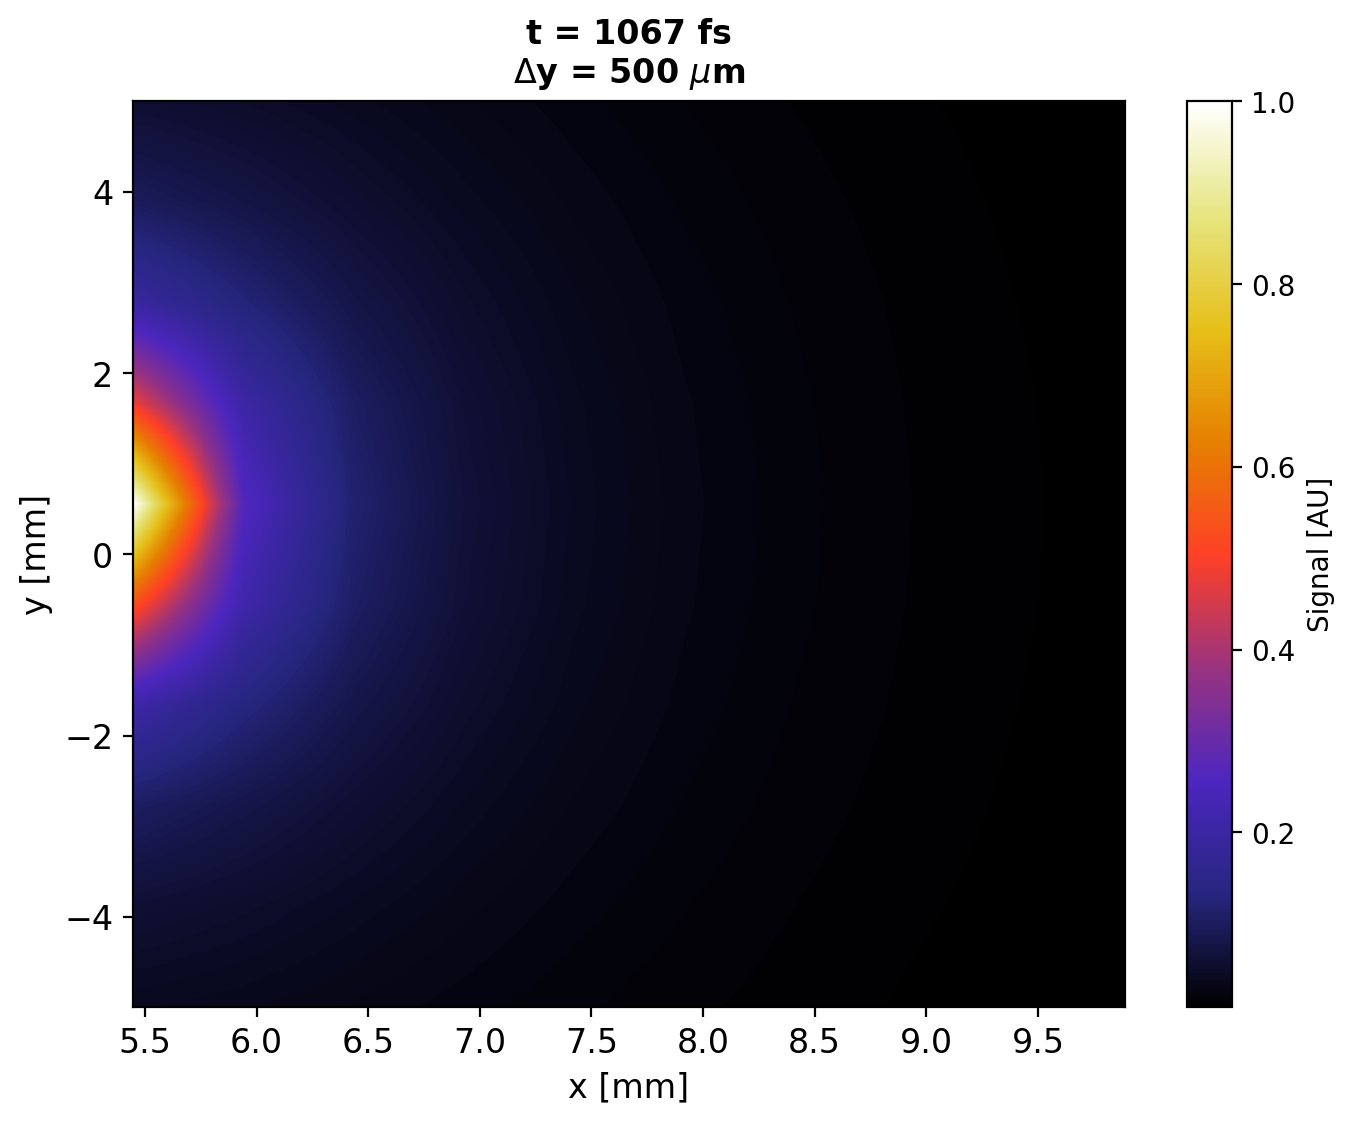

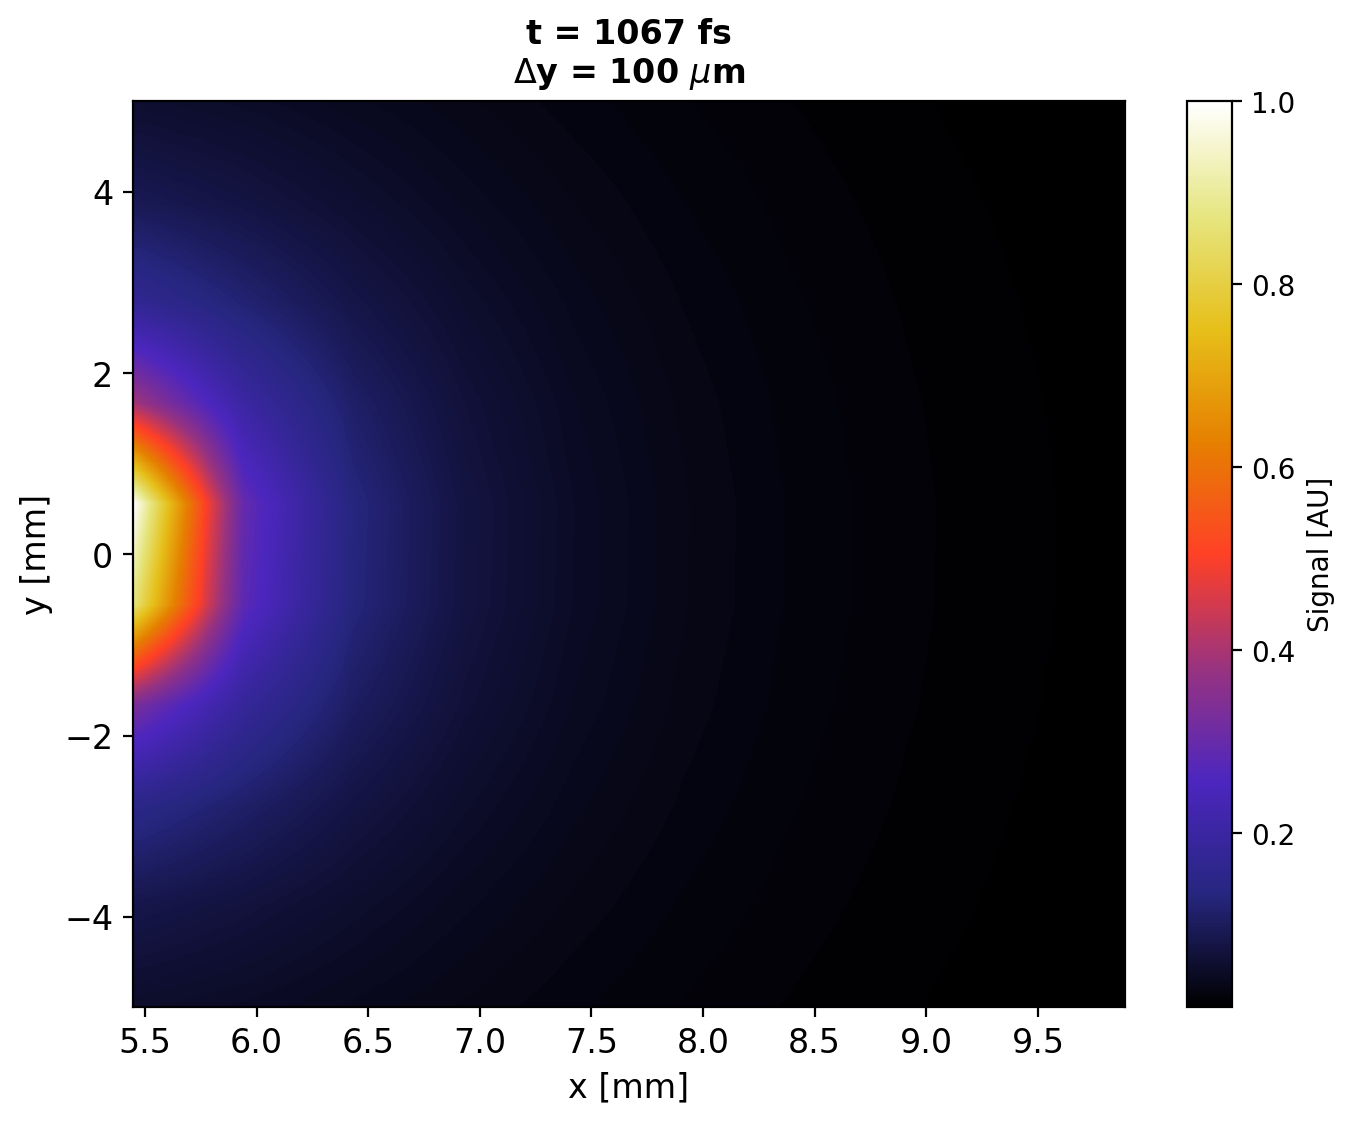

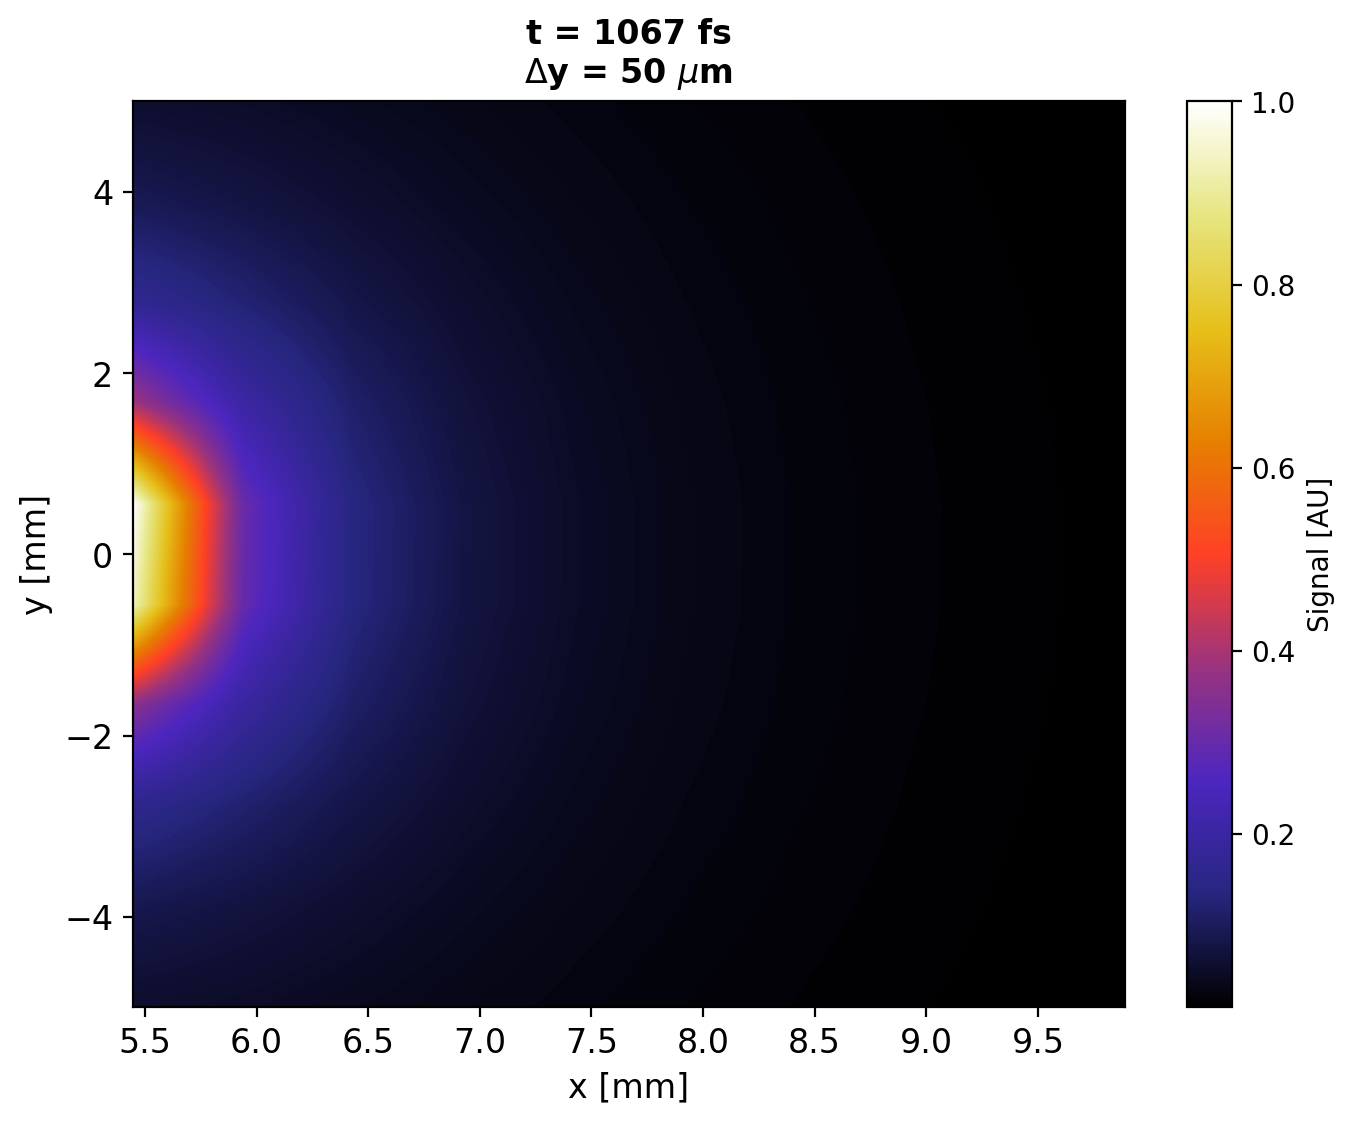

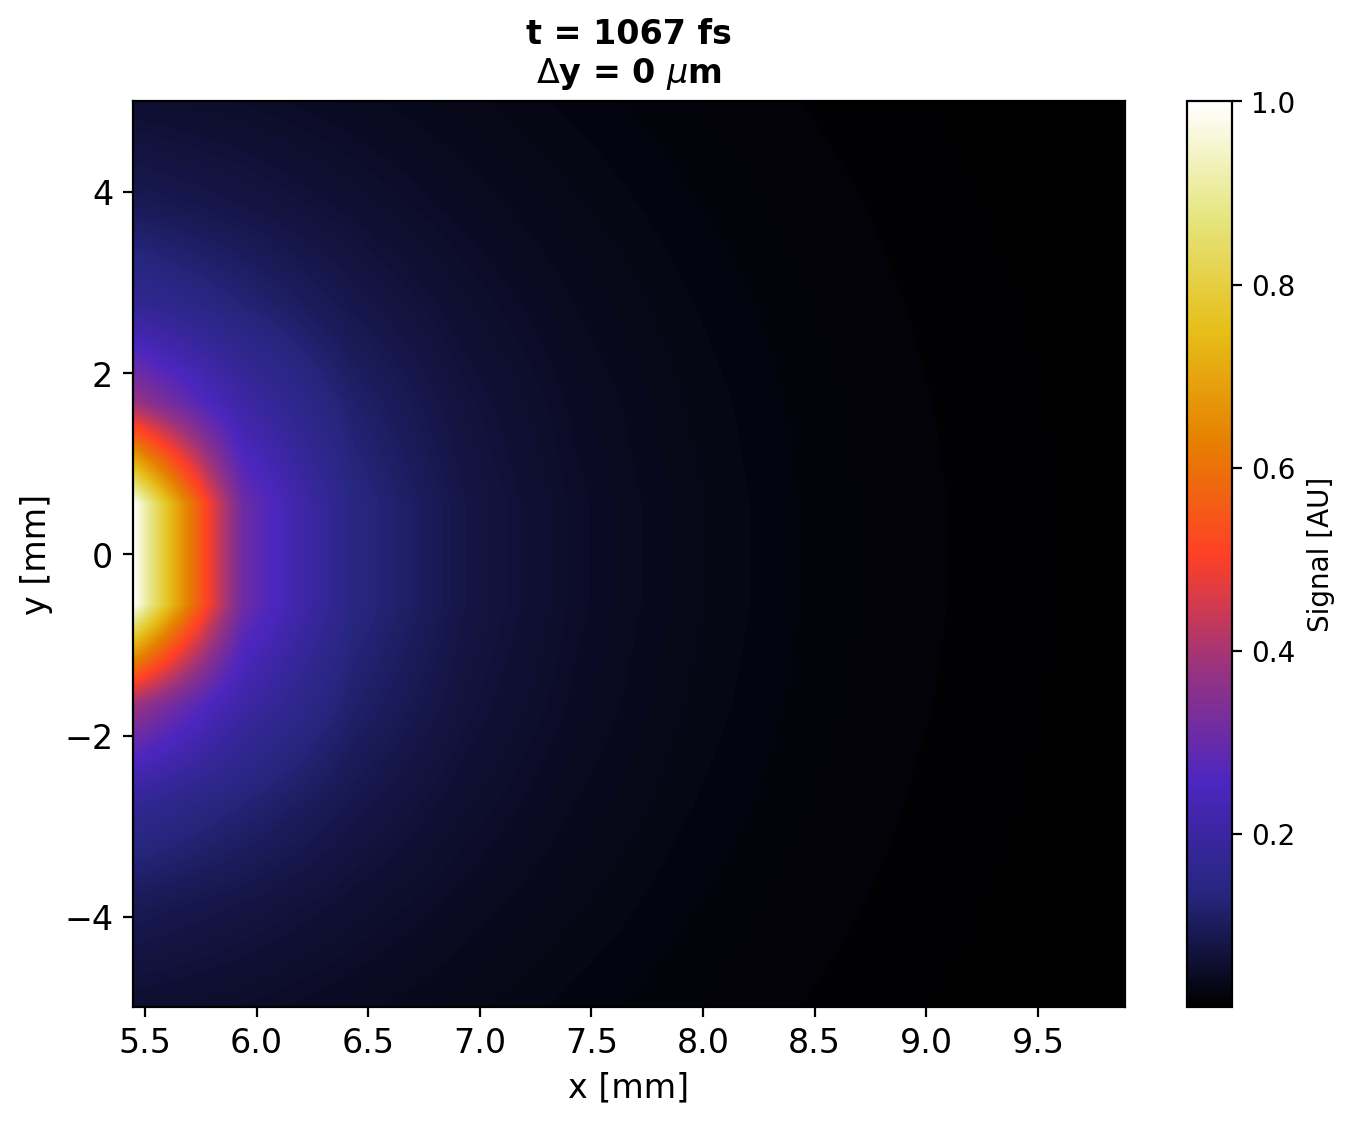

In [27]:
# Witness Phase retardation (crystal 5mm from beamline)
xline = 0;
phase = False;
sname = '5mm_wit_sig_';
x5_ind = np.argmin(abs(x - 5e-3));
x5 = x[x5_ind:-1]
wit_sig1 = gamma1_wit_int;
ext = np.array([min(x5), max(x5), min(y), max(y)]) * 1e3;
tstring = "t = 1067 fs" + "\n" +  r'$\Delta$y = 1 mm'
plot_sig(wit_sig1, ext, tstring, xline = xline, phase = phase, sname = sname + '1mm_off.svg')

wit_sig500 = gamma500_wit_int;
ext = np.array([min(x5), max(x5), min(y), max(y)]) * 1e3;
tstring = "t = 1067 fs" + "\n" +  r'$\Delta$y = 500 $\mu$m'
plot_sig(wit_sig500, ext, tstring, xline = xline, phase = phase, sname = sname + '500um_off.svg')

wit_sig100 = gamma100_wit_int;
ext = np.array([min(x5), max(x5), min(y), max(y)]) * 1e3;
tstring = "t = 1067 fs" + "\n" +  r'$\Delta$y = 100 $\mu$m'
plot_sig(wit_sig100, ext, tstring, xline = xline, phase = phase, sname = sname + '100um_off.svg')

wit_sig50 = gamma50_wit_int;
ext = np.array([min(x5), max(x5), min(y), max(y)]) * 1e3;
tstring = "t = 1067 fs" + "\n" +  r'$\Delta$y = 50 $\mu$m'
plot_sig(wit_sig50, ext, tstring, xline = xline, phase = phase, sname = sname + '50um_off.svg')

wit_sig0 = gamma0_wit_int;
ext = np.array([min(x5), max(x5), min(y), max(y)]) * 1e3;
tstring = "t = 1067 fs" + "\n" +  r'$\Delta$y = 0 $\mu$m'
plot_sig(wit_sig0, ext, tstring, xline = xline, phase = phase, sname = sname + '0_off.svg')

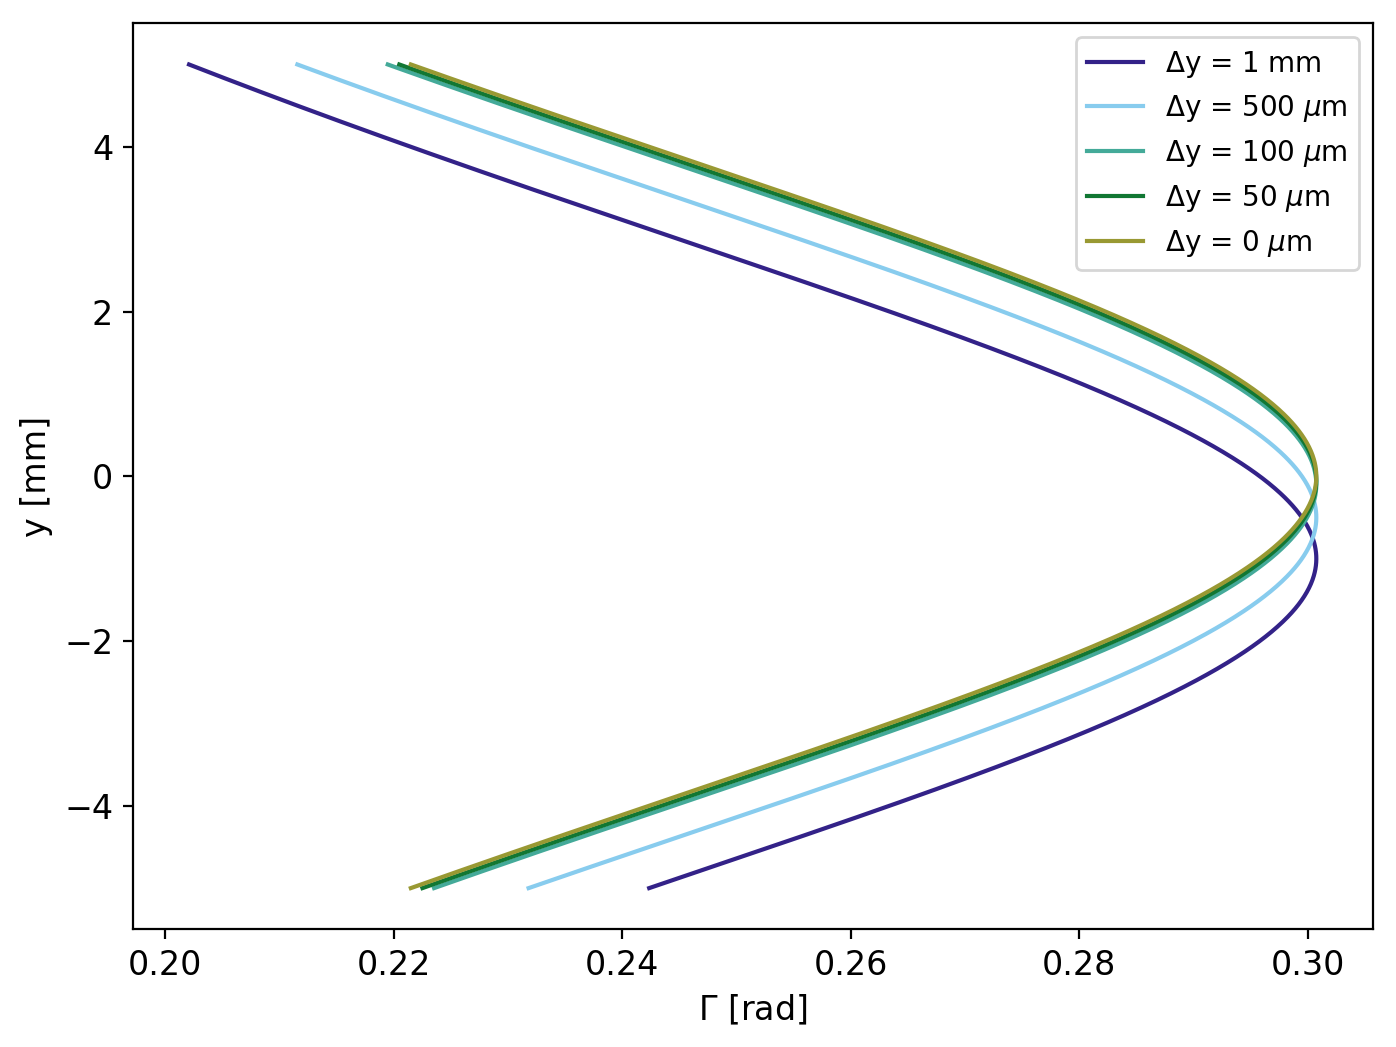

In [25]:
#Lineouts
fig, ax = makefig(x = 8, y = 6, xlab = r'$\Gamma$ [rad]', ylab = 'y [mm]');
#x_ind = np.argmin(abs(x - 5.5e-3));
#line1   = np.sin(gamma1[533, x_ind, :] / 2)**2;
#line500 = np.sin(gamma500[533, x_ind, :] / 2)**2;
#line100 = np.sin(gamma100[533, x_ind, :] / 2)**2;
#line50  = np.sin(gamma50[533, x_ind, :] / 2)**2;
#line0   = np.sin(gamma0[533, x_ind, :] / 2)**2;
#norm = max(line0);

line1   = gamma1[533, x_ind, :];
line500 = gamma500[533, x_ind, :];
line100 = gamma100[533, x_ind, :];
line50  = gamma50[533, x_ind, :];
line0   = gamma0[533, x_ind, :];
norm = 1;


ax.plot(line1 / norm, y*1e3, label = r'$\Delta$y = 1 mm');
ax.plot(line500 / norm, y*1e3, label = r'$\Delta$y = 500 $\mu$m');
ax.plot(line100 / norm, y*1e3, label = r'$\Delta$y = 100 $\mu$m');
ax.plot(line50 / norm, y*1e3, label = r'$\Delta$y = 50 $\mu$m');
ax.plot(line0 / norm, y*1e3, label = r'$\Delta$y = 0 $\mu$m');
ax.legend()
fig.savefig('5mm_wit_lineout.svg')
plt.show()